<h1 style="font-family:Corbel Light; color:#97a9fd">Projet 7 : Implémentez un modèle de scoring </h1>

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#97a9fd">Étape 1</span> : Algorithme de classification </h2>

<h3 style="font-family:Corbel Light; color:#737373">Requirements</h3>

In [1]:
import pandas as pd
import numpy as np
import os
import json

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import toolbox
from toolbox import DataFile
import shap
import gc

import time
from time import perf_counter

from contextlib import contextmanager

import lightgbm
from lightgbm import LGBMClassifier

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, confusion_matrix, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.utils import resample, class_weight
from sklearn import set_config

import xgboost as xgb
import catboost as ctb

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

import logging
from enum import Enum

import hyperopt
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope
from math import ceil
from functools import partial

import dill

import evidently
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
python_version = !python -V
print('python version :', python_version, '\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('sci-kit learn version : ', sklearn.__version__, '\n')
print('lightgbm version : ', lightgbm.__version__, '\n')
print('mlflow version : ', mlflow.__version__, '\n')
print('imblearn version :', imblearn.__version__, '\n')
print('dill version :', dill.__version__,'\n')
print('evidently version :', evidently.__version__,'\n')

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.6 

matplotlib version :  3.5.1 

seaborn version :  0.12.2 

sci-kit learn version :  1.2.2 

lightgbm version :  3.3.5 

mlflow version :  2.3.2 

imblearn version : 0.10.1 

dill version : 0.3.6 

evidently version : 0.3.3 



**Versions utilisées :**

- python : Python 3.9.12 
- seaborn    :  0.12.1
- matplotlib :  3.5.1 
- numpy  :  1.21.6 
- pandas :  1.4.2
- sklearn :  1.2.2
- lightgbm : 3.3.5
- mlflow : 2.3.2
- imbalanced-learn : 0.10.1
- dill : 0.3.6 
- evidently : 0.3.3

<h3 style="font-family:Corbel Light; color:#737373">Analyse Exploratoire</h3>

https://www.kaggle.com/c/home-credit-default-risk/data

Nous avons 10 fichiers contenant : 
- les demandes de crédit déposées auprès de la société "Prêt à dépenser"
    - *'application_test.csv'* : jeu de test (121 colonnes)
    - *'application_train.csv'* : jeu d'entrainement(121 colonnes + cible : 0 = crédit accordé, 1 = refusé)
- *'bureau.csv'* : les demandes de crédit adressées à d'autres institutions financières et recensées par le bureau de crédit
- *'bureau_balance.csv'* : les mensualités associées aux crédits accordés par d'autres institutions financières et recensés par le bureau de crédit
- *'POS_CASH_balance.csv'* : échéancier des mensualités associées aux prêts à la consommation déjà accordés par la société "Prêt à dépenser"
- *'credit_card_balance.csv'* : échéancier des mensualités associées aux prêts adossés à une carte de crédit, déjà accordés par la société "Prêt à dépenser"
- *'previous_application.csv'* : les anciennes demandes de crédit faites auprès de la société "Prêt à dépenser"
- *'installments_payments.csv'* : écheancier des crédits déjà accordés par la société "Prêt à dépenser"
- *'sample_submission.csv'* : des exemples de résultats de classification
- *'HomeCredit_columns_description'* : la description des variables de tous ces jeux de données

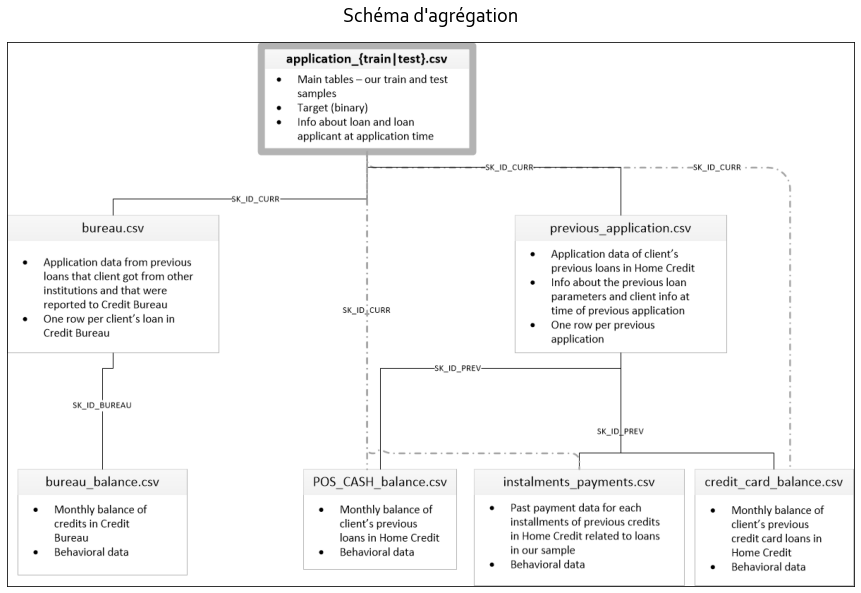

In [4]:
url = 'https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png'
toolbox.display_image_from_url(url, 'Schéma d\'agrégation', (20, 10))

<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit auprès de la société "Prêt à dépenser" - jeu d'entraînement</h4>

In [19]:
application_train = pd.read_csv('application_train.csv')
application_train.shape

(307511, 122)

Regardons les 5 premières lignes du jeu de données :

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Regardons la structure du jeu de données :

In [7]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Regardons si le jeu de données contient des variables catégorielles

In [40]:
categorical_columns_train = [col for col in application_train.columns
                             if application_train[col].dtype == 'object']

In [41]:
categorical_columns_train

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Il semblerait que 'SK_ID_CURR' soit la clé primaire de ce jeu de données (on a bien une valeur différente pour chacun des 307_511 individus). 

Cette variable correspond à l'identifiant de chaque demande de crédit faite auprès de la société 'Prêt à dépenser' (ID of loan in our sample).

In [8]:
application_train.nunique().sort_values(ascending=False)

SK_ID_CURR            307511
EXT_SOURCE_2          119831
EXT_SOURCE_1          114584
DAYS_BIRTH             17460
DAYS_REGISTRATION      15688
                       ...  
NAME_CONTRACT_TYPE         2
FLAG_DOCUMENT_2            2
FLAG_DOCUMENT_3            2
FLAG_DOCUMENT_4            2
FLAG_OWN_REALTY            2
Length: 122, dtype: int64

Regardons si le jeu de données contient des doublons :

In [9]:
application_train.drop(columns=['SK_ID_CURR']).duplicated().sum()

0

Vérifions qu'il ne manque pas de valeurs dans la colonne 'TARGET':

In [71]:
train_missing_df = toolbox.missing_values_by_column(application_train)
train_missing_df.loc[train_missing_df['VARIABLES'] == 'TARGET']

,VARIABLES,Number of Missing Values,Missing Values (%)
1,TARGET,0,0.0


Regardons s'il manque beaucoup de valeurs dans les autres colonnes: 
il manque des valeurs pour 67 des 122 variables du jeu de données.

In [10]:
train_missing_df = train_missing_df.loc[train_missing_df['Number of Missing Values'] > 0]
train_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
95,DAYS_LAST_PHONE_CHANGE,1,0.00
29,CNT_FAM_MEMBERS,2,0.00
9,AMT_ANNUITY,12,0.00
10,AMT_GOODS_PRICE,278,0.09
42,EXT_SOURCE_2,660,0.21
...,...,...,...
84,NONLIVINGAPARTMENTS_MEDI,213514,69.43
70,NONLIVINGAPARTMENTS_MODE,213514,69.43
62,COMMONAREA_MODE,214865,69.87
48,COMMONAREA_AVG,214865,69.87


Dans le kernel Kaggle utilisé pour nettoyer nos données, 
- les individus pour lesquels la variable 'CODE_GENDER' est égale à 'XNA' sont supprimés
- les individus pour lesquels la variable 'DAYS_EMPLOYED' est égale à 365243 sont remplacés par des nan

Regardons si ces incohérences se trouvent bien dans notre jeu de données.

In [11]:
application_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [12]:
application_train[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
189640,319880,0,Revolving loans,XNA,Y,Y,0,247500.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0


In [13]:
application_train.loc[application_train['DAYS_EMPLOYED']
                      == 365243][['DAYS_EMPLOYED']]

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243
...,...
307469,365243
307483,365243
307487,365243
307505,365243


Regardons la cible :

Très fort déséquilibre de classe dans ce jeu de données, avec 92% de crédits accordés et 8% de demandes refusées.

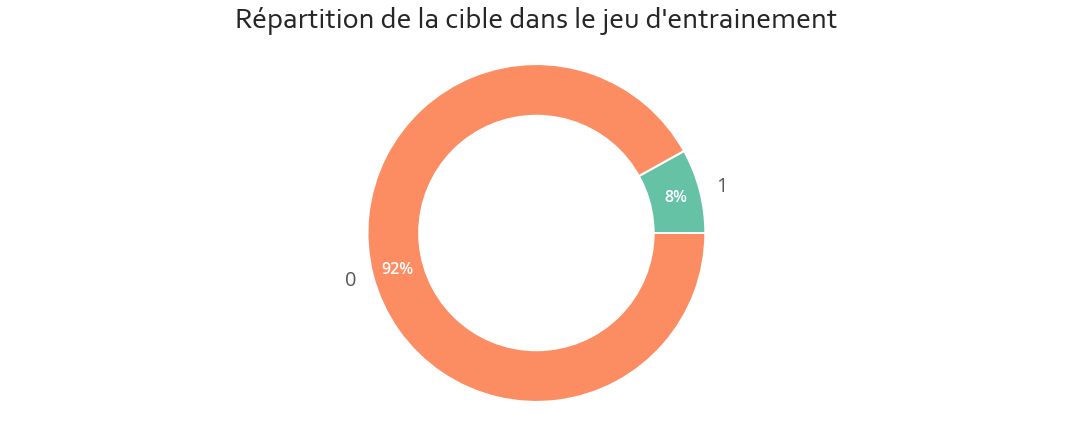

In [14]:
toolbox.plot_donut(application_train, 'TARGET',
                   'Répartition de la cible dans le jeu d\'entrainement', (15, 6))

<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit auprès de la société "Prêt à dépenser" - jeu de test</h4>

In [42]:
application_test = pd.read_csv('application_test.csv')
application_test.shape

(48744, 121)

Regardons les 5 premières lignes du jeu de données :

In [16]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Regardons la structure du jeu de données : pas de variable 'TARGET' dans le jeu de test

In [17]:
application_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


Regardons les variables catégorielles :

In [44]:
categorical_columns_test = [col for col in application_test.columns
                            if application_test[col].dtype == 'object']
categorical_columns_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

Comme pour le jeu d'entraînement, la variable 'SK_ID_CURR' est la clé primaire de ce jeu de données.

In [18]:
application_test.nunique().sort_values(ascending=False)

SK_ID_CURR           48744
EXT_SOURCE_2         38885
EXT_SOURCE_1         27207
DAYS_BIRTH           15477
DAYS_REGISTRATION    12618
                     ...  
FLAG_DOCUMENT_14         1
FLAG_DOCUMENT_13         1
FLAG_DOCUMENT_12         1
FLAG_DOCUMENT_10         1
FLAG_DOCUMENT_15         1
Length: 121, dtype: int64

Regardons si ce jeu contient des doublons :

In [19]:
application_test.drop(columns=['SK_ID_CURR']).duplicated().sum()

0

Regardons les valeurs manquantes : il manque des valeurs dans 64 des 121 variables du jeu de données.

In [20]:
test_missing_df = toolbox.missing_values_by_column(application_test)
test_missing_df = test_missing_df.loc[test_missing_df['Number of Missing Values'] > 0]
test_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
41,EXT_SOURCE_2,8,0.02
8,AMT_ANNUITY,24,0.05
91,DEF_30_CNT_SOCIAL_CIRCLE,29,0.06
93,DEF_60_CNT_SOCIAL_CIRCLE,29,0.06
92,OBS_60_CNT_SOCIAL_CIRCLE,29,0.06
...,...,...,...
83,NONLIVINGAPARTMENTS_MEDI,33347,68.41
69,NONLIVINGAPARTMENTS_MODE,33347,68.41
61,COMMONAREA_MODE,33495,68.72
47,COMMONAREA_AVG,33495,68.72


Les variables qui contiennent des données manquantes dans le jeu de test en contiennent également dans le jeu d'entraînement.

In [21]:
test_missing_df['VARIABLES'].isin(train_missing_df['VARIABLES']).value_counts()

True    64
Name: VARIABLES, dtype: int64

3 variables contiennent des données manquantes dans le jeu d'entraînement mais pas dans le jeu de test.

In [22]:
train_missing_df.loc[~train_missing_df['VARIABLES'].isin(
    test_missing_df['VARIABLES'])]

,VARIABLES,Number of Missing Values,Missing Values (%)
95,DAYS_LAST_PHONE_CHANGE,1,0.00
29,CNT_FAM_MEMBERS,2,0.00
10,AMT_GOODS_PRICE,278,0.09


Comme pour le jeu d'entraînement, regardons si le nettoyage est justifié :

In [23]:
application_test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

In [24]:
application_test.loc[application_test['DAYS_EMPLOYED']
                     == 365243][['DAYS_EMPLOYED']]

,DAYS_EMPLOYED
10,365243
17,365243
22,365243
26,365243
36,365243
...,...
48717,365243
48728,365243
48731,365243
48735,365243


<h4 style="font-family:Corbel Light; color:#737373">Demandes de crédit faites auprès d'autres institutions financières recensées par le bureau de crédit</h4>

Bureau de crédit = un service qui permet à un prêteur de connaitre la solvabilité d'un emprunteur en fournissant un rapport de crédit au sujet de cette personne.

In [25]:
bureau = pd.read_csv('bureau.csv')
bureau.shape

(1716428, 17)

Regardons les 5 premières lignes :

In [26]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Regardons la structure du jeu de données :

In [27]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


La clé primaire de ce jeu de données est 'SK_ID_BUREAU' (on a autant de valeurs différentes que de lignes).

SK_ID_BUREAU = Recorded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)

Donc on a une ligne par ancien prêt et une même demande de crédit faite auprès de la société Pret à dépenser (SK_ID_CURR) peut correspondre à plusieurs anciens prêts (SK_ID_BUREAU).

In [28]:
bureau.nunique().sort_values(ascending=False)

SK_ID_BUREAU              1716428
SK_ID_CURR                 305811
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_MAX_OVERDUE      68251
AMT_CREDIT_SUM_LIMIT        51726
AMT_ANNUITY                 40321
DAYS_CREDIT_ENDDATE         14096
DAYS_CREDIT_UPDATE           2982
DAYS_CREDIT                  2923
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_DAY_OVERDUE            942
CREDIT_TYPE                    15
CNT_CREDIT_PROLONG             10
CREDIT_CURRENCY                 4
CREDIT_ACTIVE                   4
dtype: int64

Regardons si le jeu de données contient des doublons, si l'on ne prend pas en compte la clé primaire : oui car un même client peut avoir souscrit plusieurs prêts avec les mêmes caractéristiques.

In [29]:
bureau.drop(columns=['SK_ID_BUREAU']).duplicated().sum()

2059

Regardons s'il manque des valeurs :

In [30]:
bureau_missing_df = toolbox.missing_values_by_column(bureau)
bureau_missing_df = bureau_missing_df.loc[bureau_missing_df['Number of Missing Values'] > 0]
bureau_missing_df

,VARIABLES,Number of Missing Values,Missing Values (%)
10,AMT_CREDIT_SUM,13,0.00
6,DAYS_CREDIT_ENDDATE,105553,6.15
11,AMT_CREDIT_SUM_DEBT,257669,15.01
12,AMT_CREDIT_SUM_LIMIT,591780,34.48
7,DAYS_ENDDATE_FACT,633653,36.92
8,AMT_CREDIT_MAX_OVERDUE,1124488,65.51
16,AMT_ANNUITY,1226791,71.47


<h4 style="font-family:Corbel Light; color:#737373">Mensualités associées aux prêts recensés par le bureau de crédit</h4>

In [31]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.shape

(27299925, 3)

Regardons les 5 premières lignes : 

In [32]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Regardons la structure du jeu de données : 

In [33]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


Regardons le nombre de valeurs différentes que peut prendre chacune des variables :

In [34]:
bureau_balance.nunique().sort_values(ascending=False)

SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64

La clé primaire du jeu de données est la combinaison des deux variables 'SK_ID_BUREAU' et 'MONTHS_BALANCE', car on peut avoir plusieurs mensualités par prêt.

MONTH_BALANCE = Month of balance relative to application date (-1 means the freshest balance date)

In [35]:
subset = ['SK_ID_BUREAU', 'MONTHS_BALANCE']
bureau_balance.loc[bureau_balance.duplicated(subset=subset)].shape[0]

0

Il n'y a pas de doublons

In [36]:
bureau_balance.duplicated().sum()

0

Il n'y a aucune valeur manquante

In [37]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

<h4 style="font-family:Corbel Light; color:#737373">Mensualités associées aux prêts à la consommation déjà accordés par la société "Prêt à dépenser"</h4>

In [38]:
pos = pd.read_csv('POS_CASH_balance.csv')
pos.shape

(10001358, 8)

In [39]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Regardons la structure du jeu de données :

In [40]:
pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


Regardons le nombre de valeurs différentes que peut prendre chaque variable :

In [41]:
pos.nunique().sort_values(ascending=False)

SK_ID_PREV               936325
SK_ID_CURR               337252
SK_DPD                     3400
SK_DPD_DEF                 2307
MONTHS_BALANCE               96
CNT_INSTALMENT_FUTURE        79
CNT_INSTALMENT               73
NAME_CONTRACT_STATUS          9
dtype: int64

La clé primaire du jeu de données semble être la combinaison des variables 'SK_ID_PREV' et 'MONTHS_BALANCE'. Chaque individu de ce jeu de données correspond à une mensualité d'un ancien crédit à la consommation accordé par la société "Prêt à dépenser".

'SK_ID_PREV' = ID of previous credit in Home Credit (dans ce projet Home Credit s'appelle "Prêt à dépenser") related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

In [42]:
pos.loc[pos.duplicated(subset=['SK_ID_PREV', 'MONTHS_BALANCE'])].shape[0]

0

Aucun doublon :

In [43]:
pos.duplicated().sum()

0

Il manque des valeurs dans deux variables : 'CNT_INSTALMENT' et 'CNT_INSTALMENT_FUTURE' :
- CNT_INSTALMENT : nombre total de mensualités
- CNT_INSTALMENT_FUTURE : nombre de mensualités restantes

In [44]:
pos.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

<h4 style="font-family:Corbel Light; color:#737373"> Mensualités associées aux prêts adossés à une carte de crédit (credit card loan) </h4>

In [45]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance.shape

(3840312, 23)

Regardons les 5 premières lignes :

In [46]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Regardons la structure du jeu de données :

In [47]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

Regardons le nombre de valeurs différentes que peut prendre chaque variable

In [48]:
credit_card_balance.nunique().sort_values(ascending=False)

AMT_BALANCE                   1347904
AMT_TOTAL_RECEIVABLE          1339008
AMT_RECIVABLE                 1338878
AMT_RECEIVABLE_PRINCIPAL      1195839
AMT_INST_MIN_REGULARITY        312266
AMT_DRAWINGS_CURRENT           187005
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_DRAWINGS_POS_CURRENT       168748
AMT_PAYMENT_CURRENT            163209
SK_ID_PREV                     104307
SK_ID_CURR                     103558
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_OTHER_CURRENT       1832
SK_DPD                            917
SK_DPD_DEF                        378
AMT_CREDIT_LIMIT_ACTUAL           181
CNT_DRAWINGS_POS_CURRENT          133
CNT_DRAWINGS_CURRENT              129
CNT_INSTALMENT_MATURE_CUM         121
MONTHS_BALANCE                     96
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_OTHER_CURRENT         11
NAME_CONTRACT_STATUS                7
dtype: int64

La clé primaire de cette table semble être la combinaison des deux variables 'SK_ID_PREV' et 'MONTHS_BALANCE'. Donc chaque ligne correspond à une mensualité.

- SK_ID_PREV = ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- MONTHS_BALANCE = Month of balance relative to application date (-1 means the freshest balance date)

In [49]:
subset = ['SK_ID_PREV', 'MONTHS_BALANCE']
credit_card_balance.loc[credit_card_balance.duplicated(subset=subset)].shape[0]

0

Aucun doublon :

In [50]:
credit_card_balance.duplicated().sum()

0

Regardons s'il manque des valeurs : il manque des valeurs dans 9 des 23 colonnes.

In [51]:
credit_card_missing_df = toolbox.missing_values_by_column(credit_card_balance)
credit_card_missing_df.loc[credit_card_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
9,AMT_INST_MIN_REGULARITY,305236,7.95
19,CNT_INSTALMENT_MATURE_CUM,305236,7.95
8,AMT_DRAWINGS_POS_CURRENT,749816,19.52
5,AMT_DRAWINGS_ATM_CURRENT,749816,19.52
15,CNT_DRAWINGS_ATM_CURRENT,749816,19.52
17,CNT_DRAWINGS_OTHER_CURRENT,749816,19.52
18,CNT_DRAWINGS_POS_CURRENT,749816,19.52
7,AMT_DRAWINGS_OTHER_CURRENT,749816,19.52
10,AMT_PAYMENT_CURRENT,767988,20.00


<h4 style="font-family:Corbel Light; color:#737373">Anciennes demandes de crédit faites auprès de la société "Prêt à dépenser"</h4>

In [102]:
previous_application = pd.read_csv('previous_application.csv')
previous_application.shape

(1670214, 37)

Regardons les 5 premières lignes :

In [53]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Regardons la structure du jeu de données

In [54]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

Regardons le nombre de valeurs différentes que peut prendre chaque variables :

La variable 'SK_ID_PREV' semble être la clé primaire de ce jeu de données. Chaque ligne correspond à une demande de crédit faite auprès de la société "Prêt à dépenser", qui n'a pas forcément été acceptée.

In [55]:
previous_application.nunique()

SK_ID_PREV                     1670214
SK_ID_CURR                      338857
NAME_CONTRACT_TYPE                   4
AMT_ANNUITY                     357959
AMT_APPLICATION                  93885
AMT_CREDIT                       86803
AMT_DOWN_PAYMENT                 29278
AMT_GOODS_PRICE                  93885
WEEKDAY_APPR_PROCESS_START           7
HOUR_APPR_PROCESS_START             24
FLAG_LAST_APPL_PER_CONTRACT          2
NFLAG_LAST_APPL_IN_DAY               2
RATE_DOWN_PAYMENT               207033
RATE_INTEREST_PRIMARY              148
RATE_INTEREST_PRIVILEGED            25
NAME_CASH_LOAN_PURPOSE              25
NAME_CONTRACT_STATUS                 4
DAYS_DECISION                     2922
NAME_PAYMENT_TYPE                    4
CODE_REJECT_REASON                   9
NAME_TYPE_SUITE                      7
NAME_CLIENT_TYPE                     4
NAME_GOODS_CATEGORY                 28
NAME_PORTFOLIO                       5
NAME_PRODUCT_TYPE                    3
CHANNEL_TYPE             

Regardons s'il manque des valeurs : il manque des valeurs dans 16 des 37 colonnes 

In [56]:
previous_application_missing_df = toolbox.missing_values_by_column(previous_application)
previous_application_missing_df.loc[previous_application_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
5,AMT_CREDIT,1,0.00
30,PRODUCT_COMBINATION,346,0.02
28,CNT_PAYMENT,372230,22.29
3,AMT_ANNUITY,372235,22.29
7,AMT_GOODS_PRICE,385515,23.08
34,DAYS_LAST_DUE,673065,40.30
33,DAYS_LAST_DUE_1ST_VERSION,673065,40.30
32,DAYS_FIRST_DUE,673065,40.30
31,DAYS_FIRST_DRAWING,673065,40.30
36,NFLAG_INSURED_ON_APPROVAL,673065,40.30


In [103]:
previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


<h4 style="font-family:Corbel Light; color:#737373">Echeancier des crédits déjà accordés par la société "Prêt à dépenser"</h4>

une ligne = un versement. On peut donc avoir plusieurs lignes pour un même crédit, si le client rembourse en plusieurs fois.

In [39]:
installments_payments = pd.read_csv('installments_payments.csv')
installments_payments.shape

(13605401, 8)

Regardons les 5 premières lignes :

In [58]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Regardons la structure du jeu de données

In [59]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [47]:
installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_PERC
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07,13602494.0
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04,inf
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04,NaN
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00,0.0
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03,1.0
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03,1.0
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04,1.0
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06,inf


Regardons le nombre de valeurs différentes que peut prendre chaque variable :

In [60]:
installments_payments.nunique()

SK_ID_PREV                997752
SK_ID_CURR                339587
NUM_INSTALMENT_VERSION        65
NUM_INSTALMENT_NUMBER        277
DAYS_INSTALMENT             2922
DAYS_ENTRY_PAYMENT          3039
AMT_INSTALMENT            902539
AMT_PAYMENT               944235
dtype: int64

Aucun doublon :

In [61]:
installments_payments.duplicated().sum()

0

Regardons s'il manque des valeurs : 

In [62]:
installments_payments.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

<h4 style="font-family:Corbel Light; color:#737373">Exemples de résultats de classification</h4>

In [63]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.shape

(48744, 2)

Regardons les 5 premières lignes :

In [64]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


Regardons la structure du jeu de données :

In [65]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


La clé primaire de ce jeu de données est 'SK_ID_CURR' (identifiant de la demande de crédit déposée auprès de la société 'Prêt à dépenser').

In [66]:
sample_submission.nunique()

SK_ID_CURR    48744
TARGET            1
dtype: int64

Regardons s'il manque des valeurs :

In [67]:
sample_submission.isnull().sum()

SK_ID_CURR    0
TARGET        0
dtype: int64

<h3 style="font-family:Corbel Light; color:#737373">Traitement des données (agrégation, nettoyage, feature engineering)</h3>

In [ ]:
data_dir = 'data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

Prétraitons les fichiers présentés ci-dessus pour obtenir un jeu de données propre et utilisable pour entrainer nos différents modèles.

In [8]:
raw_file_path = {DataFile.BUREAU: ['bureau.csv', 'bureau_balance.csv'],
                 DataFile.PREV: ['previous_application.csv'],
                 DataFile.POS: ['POS_CASH_balance.csv'],
                 DataFile.INS: ['installments_payments.csv'],
                 DataFile.CC: ['credit_card_balance.csv']
                 }

clean_file_path = {DataFile.BUREAU: 'bureau_data_clean.pkl',
                   DataFile.POS: 'pos_cash_balance_data_clean.pkl',
                   DataFile.CC: 'credit_card_data_clean.pkl',
                   DataFile.PREV: 'previous_applications_data_clean.pkl',
                   DataFile.INS: 'installments_data_clean.pkl',
                   }

Nettoyons le jeu d'entrainement:

In [109]:
%%time
preprocessed_data = toolbox.data_treatment('application_train.csv',
                                           raw_file_path, True, clean_file_path)

Dataset shape:  (307507, 127)
file opened
1
start preprocess PREV
fin nettoyage
fin ratio
fin agg
fin feature eng
Previous applications df shape: (338858, 106)
Process PREV - done in 1508s
2
file opened
3
start preprocess INS
Installments payments df shape: (339585, 26)
Process INS - done in 612s
4
file opened
5
CPU times: total: 25min 36s
Wall time: 38min 1s


Regardons les 5 premières lignes du jeu de données nettoyé :

In [112]:
preprocessed_data['X'].head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Regardons la structure de ce jeu de données :

In [113]:
preprocessed_data['X'].shape

(307507, 459)

In [114]:
preprocessed_data['X'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 459 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(382), int64(39), object(38)
memory usage: 1.1+ GB


Regardons s'il y a des valeurs manquantes : il manque des valeurs dans 405 des 459 colonnes

In [115]:
preprocessed_data_missing_df = toolbox.missing_values_by_column(preprocessed_data['X'])
preprocessed_data_missing_df.loc[preprocessed_data_missing_df['Number of Missing Values'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
94,DAYS_LAST_PHONE_CHANGE,1,0.00
28,CNT_FAM_MEMBERS,2,0.00
123,INCOME_PER_PERSON,2,0.00
125,PAYMENT_RATE,12,0.00
124,ANNUITY_INCOME_PERC,12,0.00
...,...,...,...
300,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.31
310,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.31
311,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.31
309,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.31


La clé primaire de ce jeu de données est 'SK_ID_CURR', on a bien une ligne par demande de crédit adressée auprès de la société "Prêt à dépenser".

In [116]:
preprocessed_data['X'].nunique().sort_values(ascending=False)

SK_ID_CURR                    307507
INSTAL_AMT_PAYMENT_MEAN       288554
INSTAL_AMT_INSTALMENT_MEAN    288183
INSTAL_AMT_INSTALMENT_SUM     288139
INSTAL_AMT_PAYMENT_SUM        287746
                               ...  
FLAG_DOCUMENT_3                    2
FLAG_MOBIL                         2
CC_SK_DPD_MIN                      1
CC_SK_ID_CURR_VAR                  1
CC_SK_DPD_DEF_MIN                  1
Length: 459, dtype: int64

In [ ]:
preprocessed_data['X'].set_index('SK_ID_CURR', inplace=True)
preprocessed_data['y']['SK_ID_CURR'] = preprocessed_data['X'].index
preprocessed_data['y'].set_index('SK_ID_CURR', inplace=True)

Enregistrons les jeux de données pour ne pas avoir à refaire cette étape à chaque modélisation.

In [118]:
preprocessed_data['X'].to_pickle(data_dir + '/application_train_clean.pkl')
preprocessed_data['y'].to_pickle(data_dir + '/application_train_target.pkl')

Nous pouvons faire de même avec le jeu de test:

In [11]:
%%time
preprocessed_data_test = toolbox.data_treatment('application_test.csv',
                                                raw_file_path, False, clean_file_path)

Dataset shape:  (48744, 126)
CPU times: total: 8.62 s
Wall time: 1min 1s


In [ ]:
preprocessed_data_test['X'].set_index('SK_ID_CURR', inplace=True)

In [26]:
preprocessed_data_test['X'].shape

(48744, 458)

In [25]:
preprocessed_data_test['X'].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,1.0,0.010417,1.0,0.010417,0.0,1.0,0.010417,1.0,0.010417,96.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,49.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
preprocessed_data_test['X'].to_pickle(data_dir + '/application_test_clean.pkl')

In [121]:
del preprocessed_data, preprocessed_data_test
gc.collect()

0

<h3 style="font-family:Corbel Light; color:#737373">Préparation des données</h3>

In [73]:
X = pd.read_pickle(data_dir + '/application_train_clean.pkl')
y = pd.read_pickle(data_dir + '/application_train_target.pkl')

<h4 style="font-family:Corbel Light; color:#737373">Echantillonnage du jeu de données</h4>

Nous allons travailler sur un échantillon représentatif du jeu de données, car mon ordinateur n'a pas suffisamment de ressources pour travailler sur le jeu entier.

In [74]:
X_sample, y_sample = resample(X, y,
                              n_samples=X.shape[0]//2,
                              stratify=y,
                              random_state=7,
                              replace=False)

In [75]:
print("X_sample shape: {}, y_sample shape: {}".format(X_sample.shape, y_sample.shape))

X_sample shape: (153753, 458), y_sample shape: (153753, 1)


Vérifions que la stratification a bien fonctionné, i.e. que l'échantillon contient les mêmes proportions de chaque classe que le jeu de données complet.

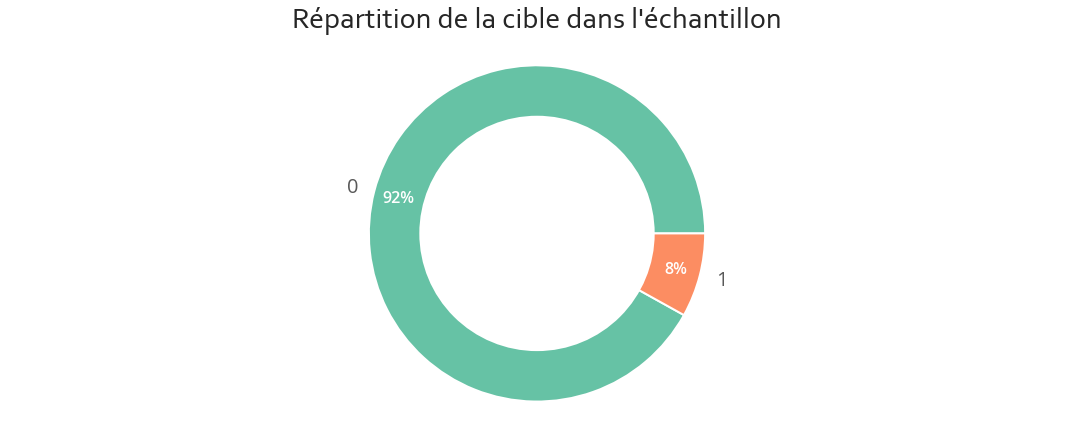

In [76]:
toolbox.plot_donut(y_sample, 'TARGET','Répartition de la cible dans l\'échantillon', (15, 6))

De même on enregistre ces échantillons de jeu de données pour ne pas avoir à refaire cette étape à chaque modélisation

In [77]:
X_sample.to_pickle(data_dir + '/X_sample.pkl')
y_sample.to_pickle(data_dir + '/y_sample.pkl')

Et on supprime les jeux complets de la mémoire vive.

In [79]:
del X, y
gc.collect()

Regardons les 5 premières lignes de notre échantillon:

In [4]:
X_sample.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309336,Cash loans,M,Y,Y,2,157500.0,888840.0,29376.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233948,Cash loans,M,N,N,0,270000.0,900000.0,55062.0,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265098,Cash loans,F,N,N,0,112500.0,517500.0,16821.0,517500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
176395,Cash loans,F,N,Y,1,126000.0,549882.0,16209.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h4 style="font-family:Corbel Light; color:#737373">Séparation en jeu d'entrainement et de test</h4>

In [81]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=8, stratify=y_sample)

CPU times: total: 5.62 s
Wall time: 7.22 s


In [82]:
print("x_train shape: {}, x_test shape: {}".format(X_train.shape, X_test.shape))

x_train shape: (107627, 458), x_test shape: (46126, 458)


On supprime les échantillons pour ne pas garder trop de données inutiles dans la mémoire vive (ce qui fait rapidement crasher l'ordinateur).

In [83]:
del X_sample, y_sample
gc.collect()

0

Vérifions que la stratification a bien fonctionné: 

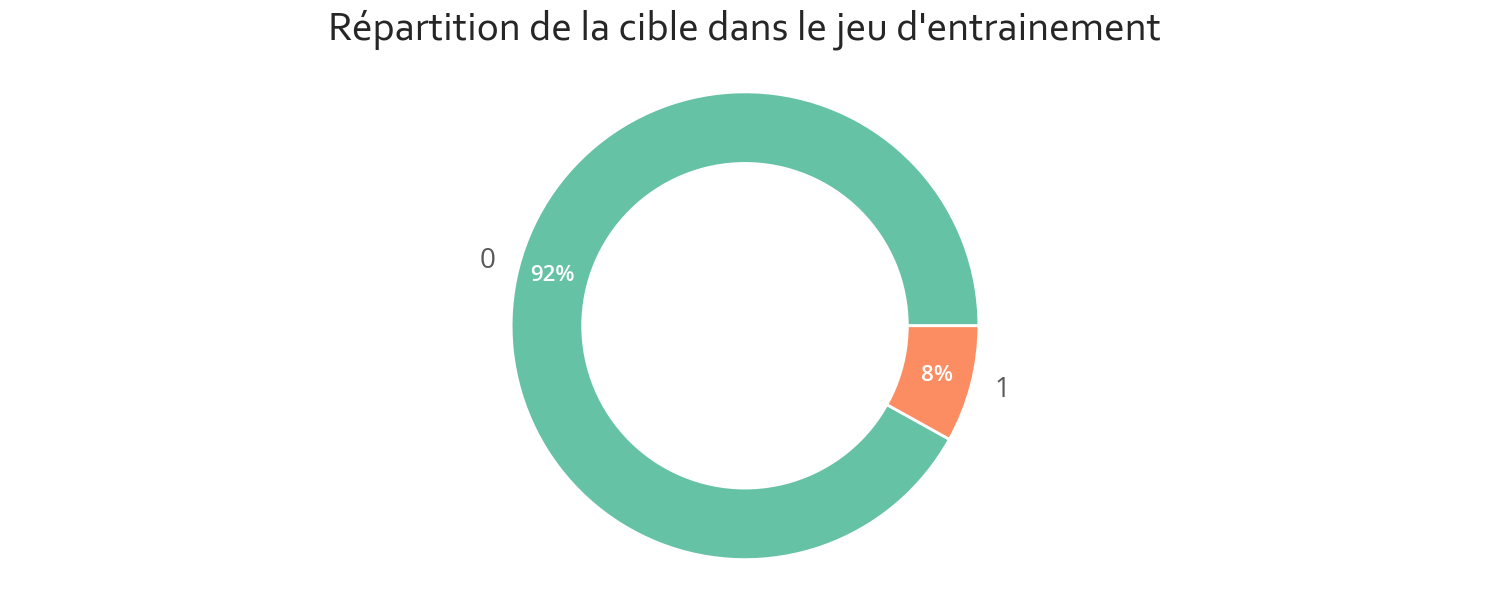

In [22]:
toolbox.plot_donut(y_train, 'TARGET','Répartition de la cible dans le jeu d\'entrainement', (15, 6))

Regardons les valeurs manquantes:

In [38]:
preprocessed_data_missing_df = toolbox.missing_values_by_column(X_train)
preprocessed_data_missing_df.loc[preprocessed_data_missing_df['Missing Values (%)'] > 0]

,VARIABLES,Number of Missing Values,Missing Values (%)
8,AMT_GOODS_PRICE,111,0.10
40,EXT_SOURCE_2,238,0.22
92,DEF_60_CNT_SOCIAL_CIRCLE,342,0.32
91,OBS_60_CNT_SOCIAL_CIRCLE,342,0.32
90,DEF_30_CNT_SOCIAL_CIRCLE,342,0.32
...,...,...,...
301,REFUSED_AMT_DOWN_PAYMENT_MEAN,91719,85.22
300,REFUSED_AMT_DOWN_PAYMENT_MAX,91719,85.22
299,REFUSED_AMT_DOWN_PAYMENT_MIN,91719,85.22
308,REFUSED_RATE_DOWN_PAYMENT_MIN,91719,85.22


<h4 style="font-family:Corbel Light; color:#737373">Test de transformations sur les variables catégorielles</h4>

In [84]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
features_categ = [col for col in X_train.columns
                  if X_train[col].dtype == 'object' and col not in binary_features]

Testons l'ordinal encoder sur les variables catégorielles qui ne prennent que deux valeurs différentes:

In [8]:
encoder = OrdinalEncoder(dtype=int)
transformed_data = encoder.fit_transform(X_train[binary_features])
transformed_data_df = pd.DataFrame(transformed_data, columns=binary_features)
print(transformed_data_df.apply(lambda col: col.unique()))

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY
0            0             0                1
1            1             1                0


Testons le OneHotEncoder qui ajoute une colonne par modalité, sur les autres variables catégorielles: 

In [6]:
categ_col = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
transformed_data = one_hot_encoder.fit_transform(X_train[categ_col])

In [7]:
pd.DataFrame(transformed_data.toarray(),
             columns=one_hot_encoder.get_feature_names_out()).head()

,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [85]:
len(features_categ)

35

**Problème** : OneHotEncoder de sklearn met beaucoup trop de temps à encoder les 35 variables catégorielles de notre jeu de données (l'encodage n'est toujours pas fini au bout de 20 minutes).

On va donc utiliser get_dummies de pandas, qui est bien plus rapide (1 min) et créer notre propre classe d'encoder "GetDummiesTransformer" (voir toolbox.py)

Vérifions que les méthodes de notre nouvelle classe fonctionnent bien:

In [139]:
df_train = pd.DataFrame(data=['cat', 'cat', 'dog', 'cat',
                              'parrot', 'dog', 'parrot'], columns=['Type'])
df_test = pd.DataFrame(data=['cat', 'parrot', 'cat', 'cat',
                       'dog', 'dog', 'parrot', 'rat'], columns=['Type'])

df_train['Color'] = ['grey', 'blue', 'green', 'red', 'green', 'grey', np.nan]
df_test['Color'] = ['grey', 'yellow', 'green',
                    'yellow', np.nan, 'pink', 'red', 'pink']

In [165]:
dummies = toolbox.GetDummiesTransformer()

In [166]:
dummies.fit_transform(df_train)

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red
0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1
4,0,0,1,0,1,0,0
5,0,1,0,0,0,1,0
6,0,0,1,0,0,0,0


In [147]:
dummies.transform(df_test)

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red
0,1,0,0,0,0,1,0
1,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0
6,0,0,1,0,0,0,1
7,0,0,0,0,0,0,0


Comparons avec les résultats obtenus en appliquant le one hot encoder:

In [148]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [159]:
one_hot_encoded_data = one_hot_encoder.fit_transform(df_train)
one_hot_encoded_data_df = pd.DataFrame(transformed_data.toarray(),
                                       columns=one_hot_encoder.get_feature_names_out()).head()
one_hot_encoded_data_df

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red,Color_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [168]:
one_hot_encoded_data = one_hot_encoder.transform(df_test)
one_hot_encoded_data_df = pd.DataFrame(transformed_data.toarray(),
                                       columns=one_hot_encoder.get_feature_names_out())
one_hot_encoded_data_df

,Type_cat,Type_dog,Type_parrot,Color_blue,Color_green,Color_grey,Color_red,Color_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Appliquons cette transformations à l'ensemble du jeu d'entrainement : on obtient un jeu de données final avec 725 variables

In [86]:
%%time
dummies = toolbox.GetDummiesTransformer(features_categ)
transformed_data = dummies.fit_transform(X_train)

CPU times: total: 3.11 s
Wall time: 5.73 s


In [87]:
transformed_data.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,POS_NAME_CONTRACT_STATUS_MODE_Amortized debt,POS_NAME_CONTRACT_STATUS_MODE_Approved,POS_NAME_CONTRACT_STATUS_MODE_Completed,POS_NAME_CONTRACT_STATUS_MODE_Demand,POS_NAME_CONTRACT_STATUS_MODE_Returned to the store,POS_NAME_CONTRACT_STATUS_MODE_Signed,CC_NAME_CONTRACT_STATUS_MODE_Active,CC_NAME_CONTRACT_STATUS_MODE_Completed,CC_NAME_CONTRACT_STATUS_MODE_Demand,CC_NAME_CONTRACT_STATUS_MODE_Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
255569,F,N,Y,0,63900.0,337500.0,12852.0,337500.0,0.015221,-22848,...,0,0,0,0,0,0,1,0,0,0
180425,F,N,Y,0,126000.0,165915.0,9130.5,126000.0,0.031329,-22303,...,0,0,0,0,0,0,0,0,0,0
293934,F,N,Y,1,180000.0,1575000.0,43312.5,1575000.0,0.030755,-13290,...,0,0,0,0,0,0,1,0,0,0
436431,F,N,Y,1,157500.0,256500.0,15628.5,256500.0,0.010032,-13424,...,0,0,0,0,0,0,1,0,0,0
288883,F,N,N,0,121500.0,1520253.0,44581.5,1327500.0,0.003069,-12742,...,0,0,0,0,0,0,0,0,0,0


<h4 style="font-family:Corbel Light; color:#737373">Test transformations variables numériques</h4>

Testons le SimpleImputer qui permet ici de remplacer les valeurs manquantes (dans les variables numériques) par la médiane de chaque variable.

In [23]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [24]:
%%time
transformed_data = imputer.fit_transform(transformed_data)

CPU times: total: 59.2 s
Wall time: 16min 2s


<h4 style="font-family:Corbel Light; color:#737373">Test transformations pour rééquilibrer le jeu d'entraînement</h4>

Rappel : notre jeu de données est fortement déséquilibré car seuls 8% des demandes de prêts ont été refusées (classe 1). Un modèle entraîné sur ce jeu déséquilibré risque d'ignorer complètement la classe 1 et donc d'être très mauvais pour identifier les demandes de crédit qu'il vaudrait mieux refuser. Or, ce sont ces demandes que l'on cherche précisément à identifier.

2 types de stratégies :
- Ajouter des individus de la classe 1 (Over Sampling)
- Supprimer des individus de la classe 0 (Under Sampling) -> perte d'informations

Nous allons tester ces techniques sur un échantillon du jeu d'entrainement pour ne pas utiliser toute la RAM.

In [31]:
X_train_sample, y_train_sample = resample(X_train, y_train,
                                          n_samples=1_000, stratify=y_train)

In [32]:
X_train_sample.shape

(1000, 458)

Commençons par appliquer les transformations vues précédemment à cet échantillon de jeu d'entrainement:

In [33]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
features_categ = [col for col in X_train.columns
                  if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

transformers_features = [{'feature': binary_features,
                          'estimator': [OrdinalEncoder(dtype=int)]},
                         {'feature': features_categ,
                          'estimator': [toolbox.GetDummiesTransformer()]},
                         {'feature': numeric_features,
                          'estimator': [SimpleImputer(missing_values=np.nan, strategy='median')]}
                         ]

In [34]:
preprocessor = make_preprocessor(transformers_features)

In [35]:
X_train_sample_trans = preprocessor.fit_transform(X_train_sample)

**Technique 1** : Random Under Sampling - Supprime au hasard des individus de la classe majoritaire (0)

In [46]:
rus = RandomUnderSampler(random_state=8)
x_rus, y_rus = rus.fit_resample(X_train_sample_trans, y_train_sample)

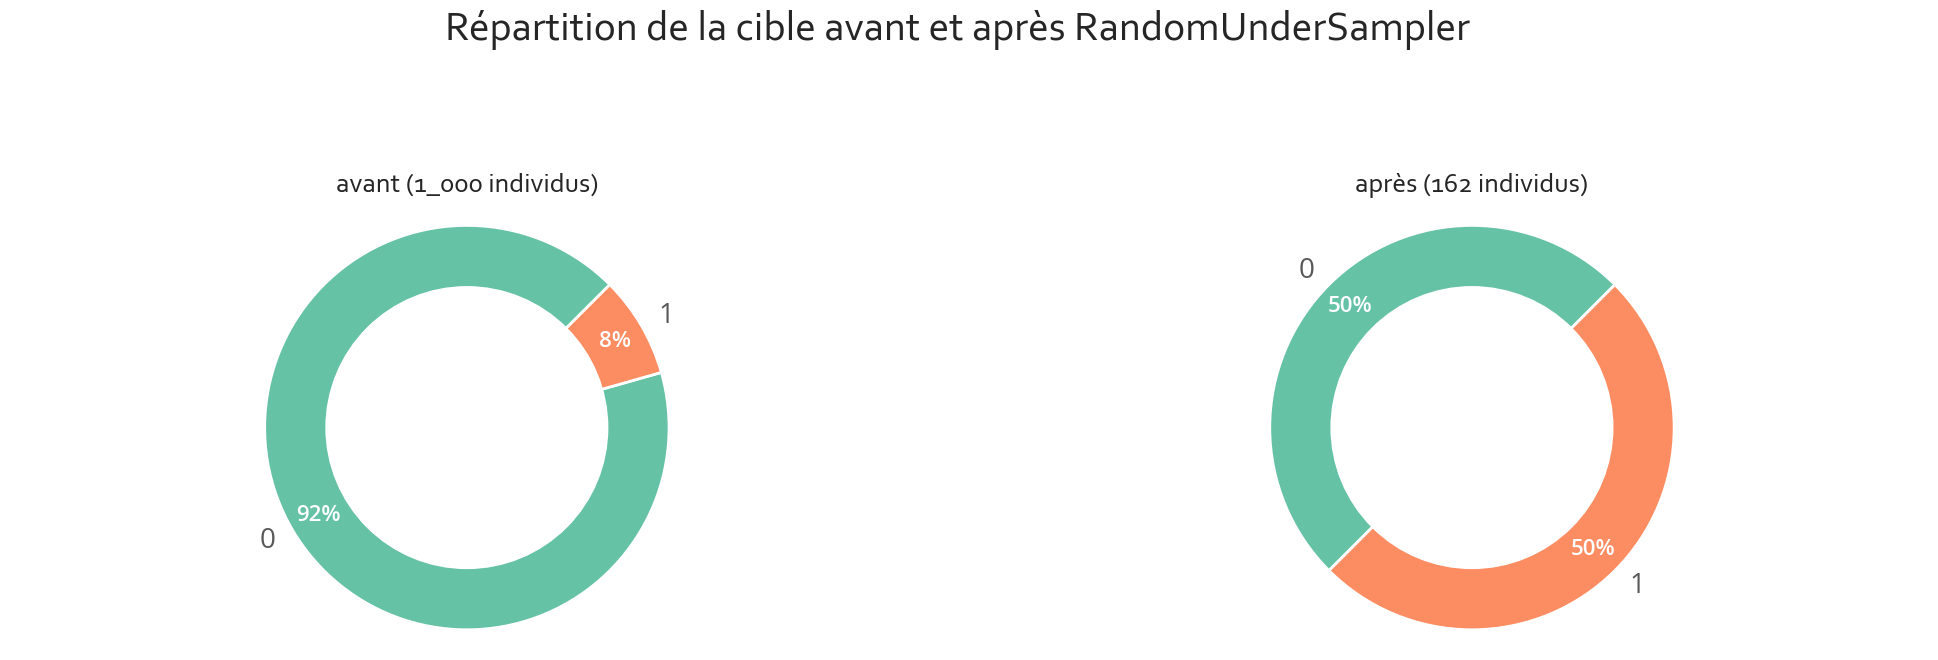

In [47]:
toolbox.compare_donuts(y_train_sample, y_rus, 'TARGET',
                       'Répartition de la cible avant et après RandomUnderSampler', (20, 7), top=0.7)

In [48]:
del rus, y_rus, x_rus
gc.collect()

6456

**Technique 2** : Under Sampling Tomek Links - Supprime tout individu de la classe 0 qui est le plus proche voisin d'un individu de la classe 1.

*Rmq: Ne fonctionne pas sur un jeu de données contenant des nan*

In [49]:
tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(X_train_sample_trans, y_train_sample)

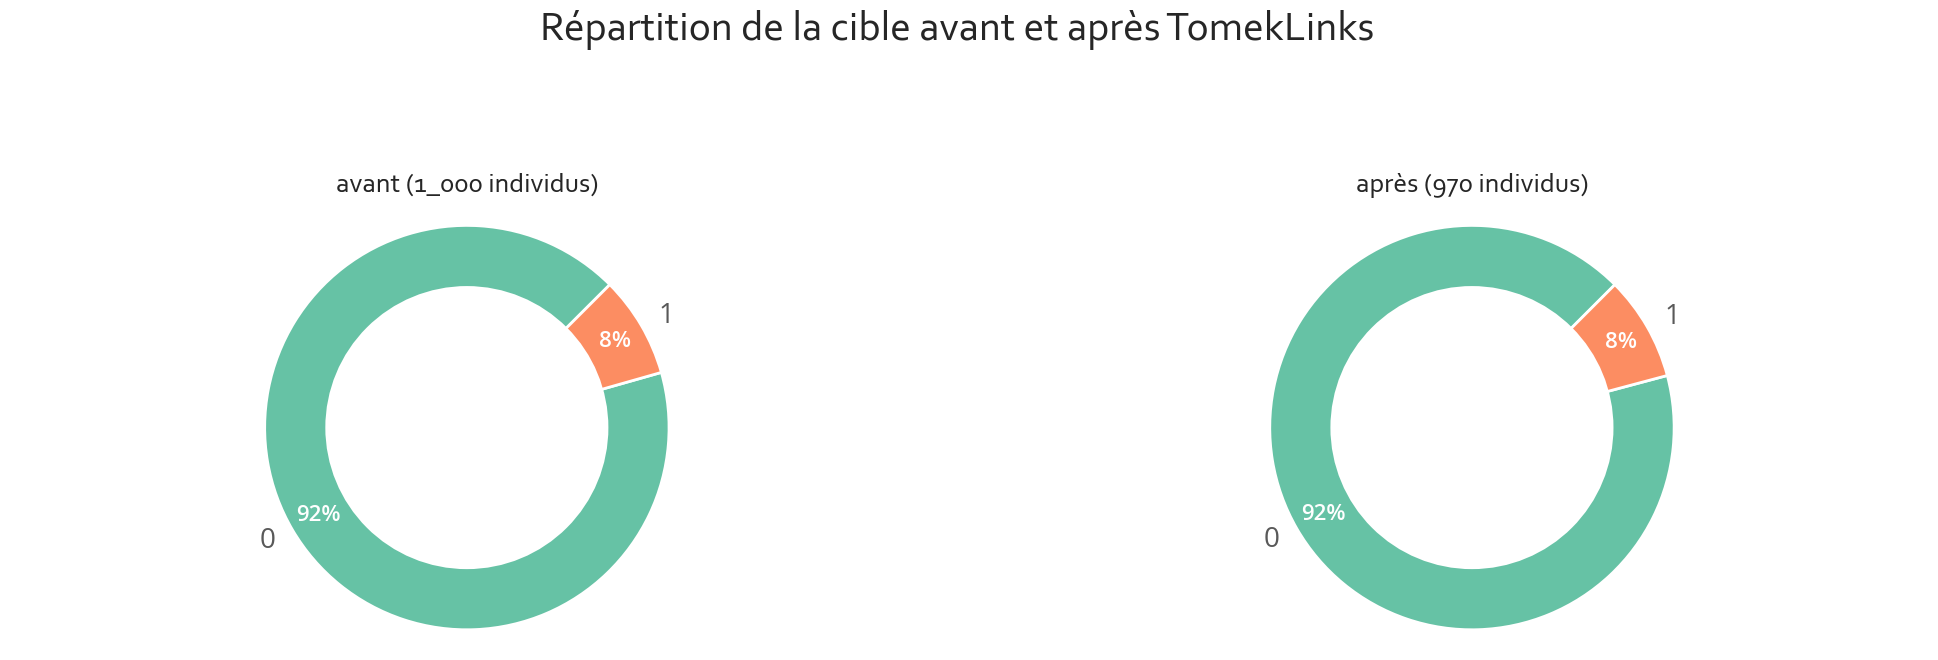

In [51]:
toolbox.compare_donuts(y_train_sample, y_tl, 'TARGET',
                       'Répartition de la cible avant et après TomekLinks', (20, 7), top=0.7)

In [55]:
del tl, y_tl, x_tl
gc.collect()

7605

**Technique 3** : Random Over Sampling - tire des individus de la classe 1 au hasard, avec remise, pour les ajouter au jeu de données, jusqu'à ce qu'on ait le même nombre d'individus dans les 2 classes.

*Problème : mon ordinateur ne supporte pas de travailler sur un jeu de données aussi gros. Cette technique le fait crasher.*

In [56]:
ros = RandomOverSampler(random_state=8)
x_ros, y_ros = ros.fit_resample(X_train_sample_trans, y_train_sample)

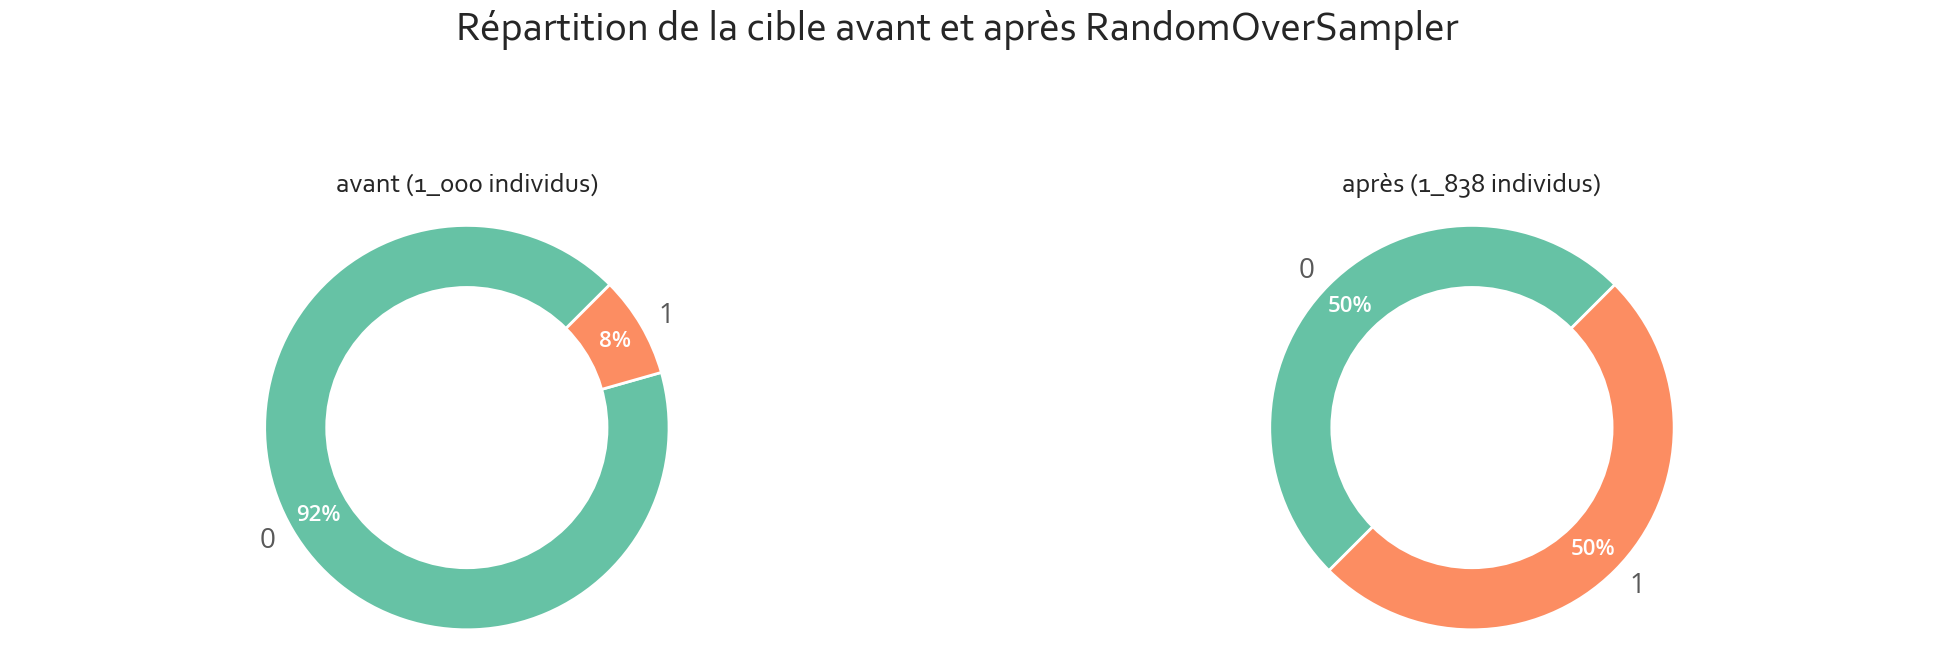

In [57]:
toolbox.compare_donuts(y_train_sample, y_ros, 'TARGET',
                       'Répartition de la cible avant et après RandomOverSampler', (20, 7), top=0.7)

In [58]:
del ros, y_ros, x_ros
gc.collect()

6197

**Technique 4** : SMOTE (Synthetic Minority Oversampling Technique)

L'algorithme :
- tire un individu de la classe minoritaire au hasard
- calcule ses k plus proches voisins 
- tire un des plus proches voisins au hasard
- relie ces deux points par une droite et choisit un point de cette droite au hasard comme nouvel individu.

*Rmq : SMOTE ne fonctionne pas sur un jeu de données contenant des nan*

In [60]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train_sample_trans, y_train_sample)

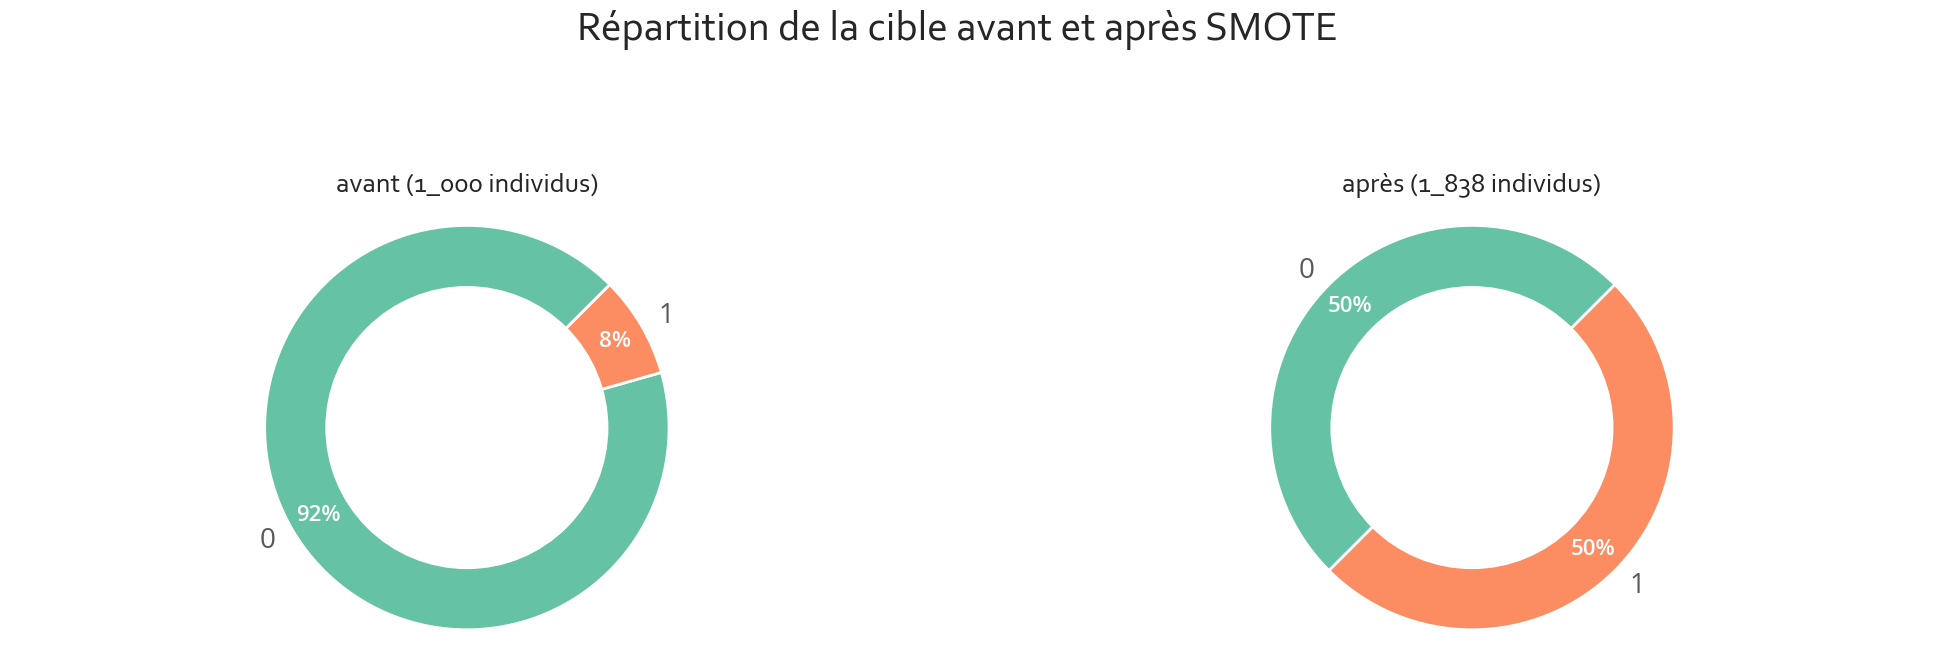

In [62]:
toolbox.compare_donuts(y_train_sample, y_smote, 'TARGET',
                       'Répartition de la cible avant et après SMOTE', (20, 7), top=0.7)

In [64]:
del smote, y_smote, x_smote
gc.collect()

12453

**Technique 5** : NearMiss - Undersampling - Supprime les individus de la classe 0 très proches d'individus de la classe 1, pour augmenter l'espace entre les deux classes.

*Rmq: Ne fonctionne pas sur un jeu de données contenant des nans*

In [63]:
nm = NearMiss()
x_nm, y_nm = nm.fit_resample(X_train_sample_trans, y_train_sample)

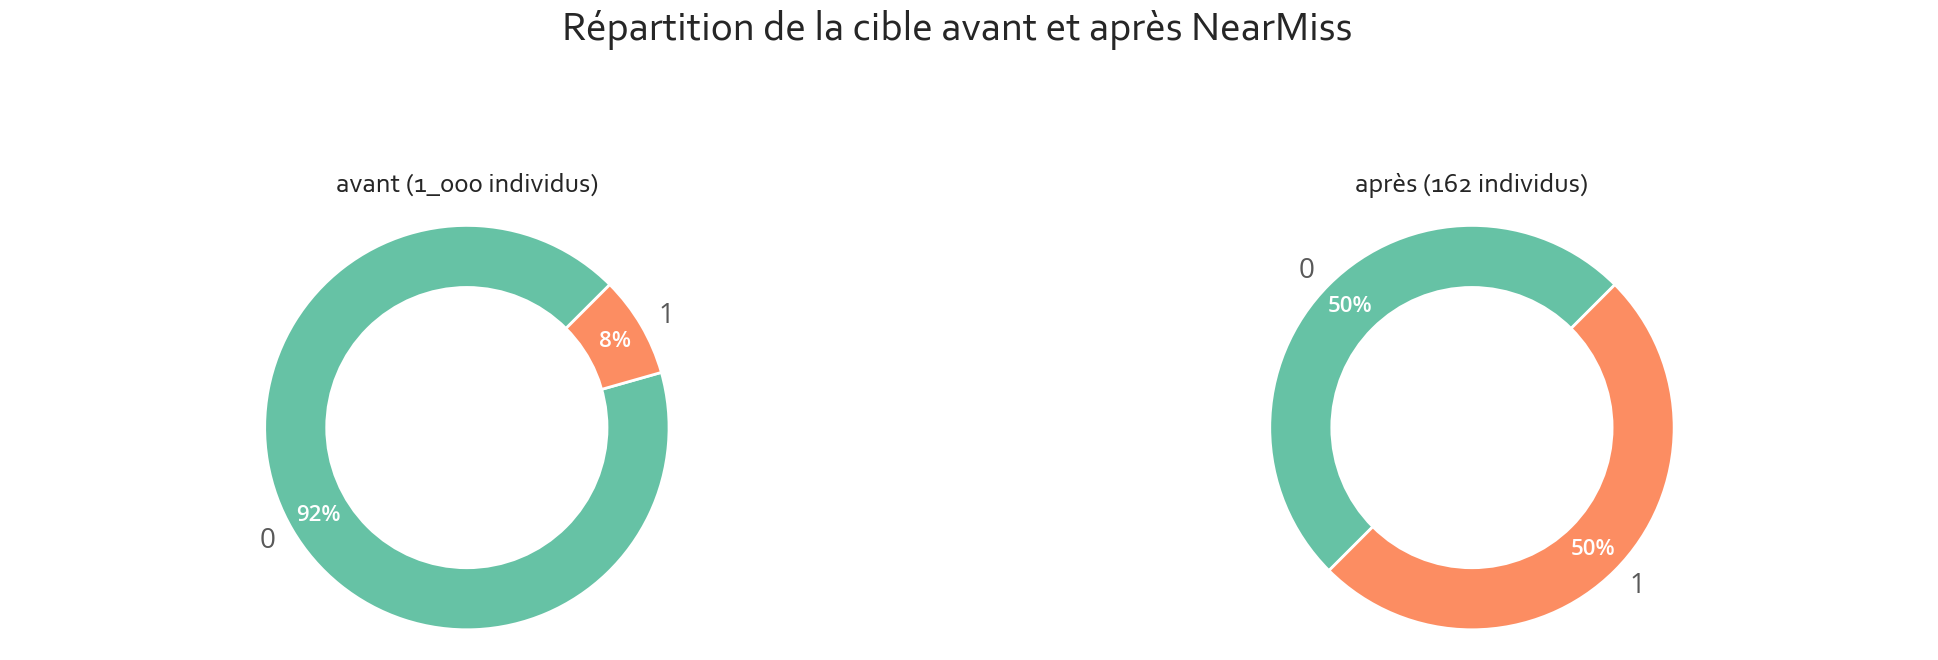

In [67]:
toolbox.compare_donuts(y_train_sample, y_nm, 'TARGET',
                       'Répartition de la cible avant et après NearMiss', (20, 7), top=0.7)

In [68]:
del nm, y_nm, x_nm
gc.collect()

12418

**Technique 6**: Utiliser l'hyperparamètre 'class_weight' pour, lors du scoring, pondérer chaque individu selon la classe à laquelle il appartient.

Si class_weight = 'balanced': poids classe j = nombre d'observations / (nb de classes * nb d'individus dans la classe j)

In [72]:
class_weight.compute_class_weight('balanced',
                                  classes=np.unique(y_train_sample),
                                  y=y_train_sample['TARGET'])

array([0.54406964, 6.17283951])

**Technique 7** : Combiner oversampling et undersampling

On applique SMOTE pour ajouter des individus dans la classe minoritaire et RandomUnderSampling pour réduire le nombre d'individus dans la classe majoritaire.

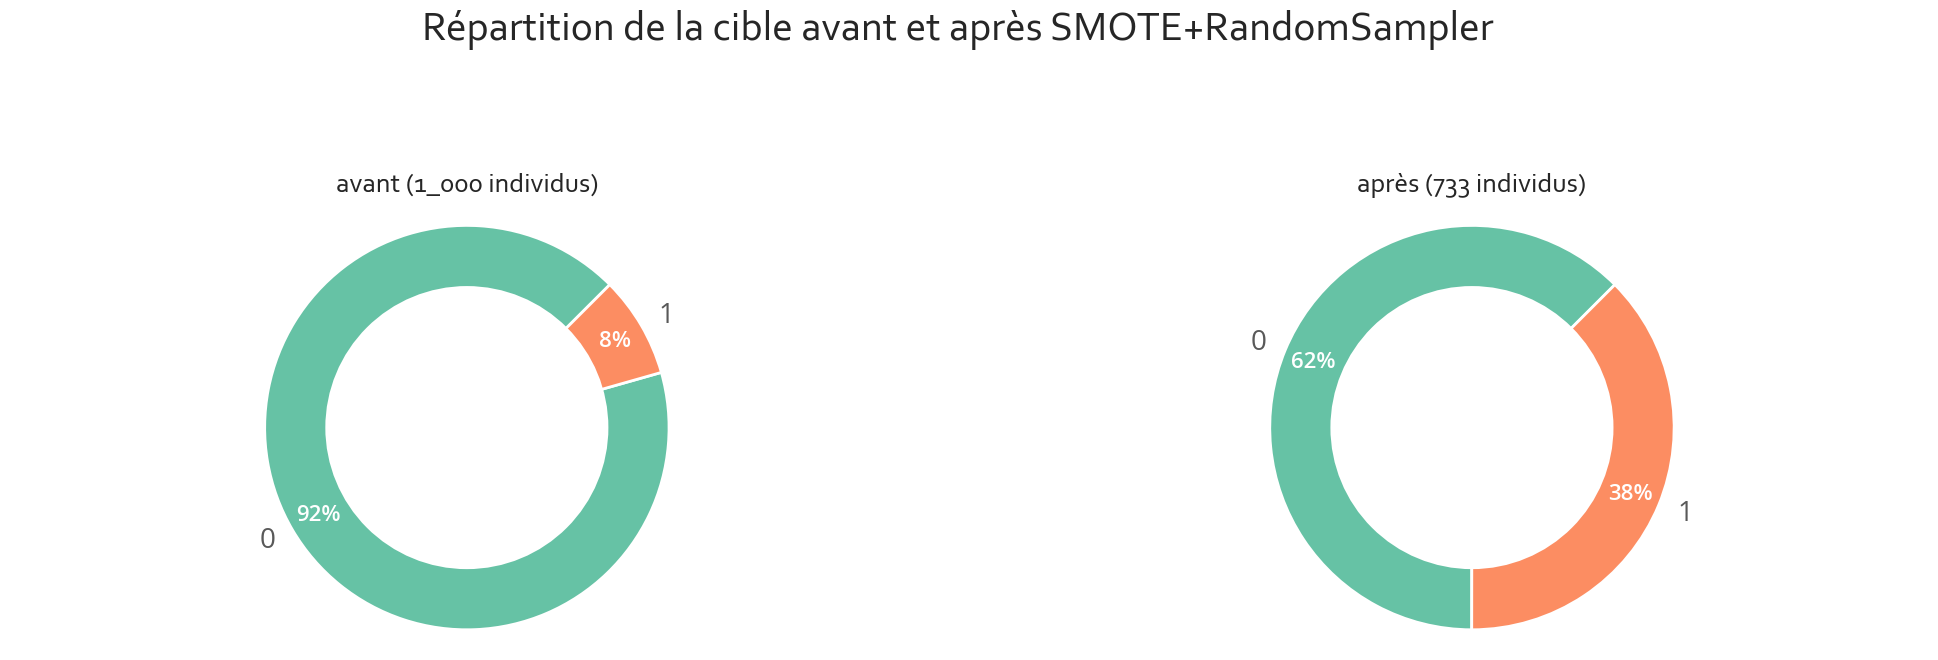

In [58]:
pipeline = imb_make_pipeline(SMOTE(random_state=8, sampling_strategy=0.3),
                             RandomUnderSampler(random_state=8, sampling_strategy=0.6))

x_rus_smote, y_rus_smote = pipeline.fit_resample(X_train_sample_trans,
                                                 y_train_sample)

toolbox.compare_donuts(y_train_sample, y_rus_smote, 'TARGET',
                       'Répartition de la cible avant et après SMOTE+RandomSampler',
                       (20, 7), top=0.7)

<h4 style="font-family:Corbel Light; color:#737373">Test pipeline</h4>

Nous allons placer chaque modèle à tester dans un pipeline, pour éviter la fuite de données entre le jeu d'entrainement et le jeu de test lors des transformations. Regardons à quoi ressemble ce pipeline:

In [89]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in X_train.columns
                  if X_train[col].dtype == 'object' and col not in binary_features]

numeric_features = X_train._get_numeric_data().columns

In [90]:
transformers_features = [{'feature': binary_features,
                          'estimator': [OrdinalEncoder(dtype=int)]},
                         {'feature': categ_features,
                          'estimator': [toolbox.GetDummiesTransformer()]},
                         {'feature': numeric_features,
                          'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                         ]

sampler = [RandomUnderSampler(random_state=8)]

In [91]:
preprocessor = toolbox.make_preprocessor(transformers_features)

In [92]:
pipeline = imb_make_pipeline(preprocessor,
                             *sampler,
                             DummyClassifier(strategy='most_frequent'),
                             verbose=True
                             )
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('getdummiestransformer',
                                                                   <toolbox.GetDummiesTransformer object at 0x0000015E94ADBF10>)]),
                                                  ['NAM...
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=420))])),
                ('randomundersampler', RandomUnderSampler(random_state=8)),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [94]:
%%time
pipeline.fit(X_train, y_train)

[Pipeline] . (step 1 of 3) Processing columntransformer, total=  51.3s
[Pipeline]  (step 2 of 3) Processing randomundersampler, total=   3.5s
[Pipeline] ... (step 3 of 3) Processing dummyclassifier, total=   0.4s
CPU times: total: 24.1 s
Wall time: 57.2 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('getdummiestransformer',
                                                                   <toolbox.GetDummiesTransformer object at 0x0000015E94ADBF10>)]),
                                                  ['NAM...
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=420))])),
                ('randomundersampler', RandomUnderSampler(random_state=8)),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [95]:
transformed_data = pipeline[0].transform(X_train)

On retrouve les 725 variables (comme précédemment)

In [96]:
transformed_data.shape

(107627, 725)

Essayons de retrouver les noms des variables du jeu de données transformé:

In [97]:
features_getdummies = pipeline[0].named_transformers_['pipeline-2'][0].get_feature_names()
X_train.columns.values.shape[0] - len(features_categ) + len(features_getdummies) 

725

In [98]:
features_final = [*binary_features, *features_getdummies]
features_final.extend([col for col in X_train.columns.values
                       if col not in [*features_categ, *binary_features]])
len(features_final)

725

In [99]:
transformed_data_df = pd.DataFrame(transformed_data, columns=features_final)
transformed_data_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vérifions pour quelques colonnes numériques, non transformées au hasard que les valeurs correspondent

In [106]:
transformed_data_df[['AMT_INCOME_TOTAL']].head()

,AMT_INCOME_TOTAL
0,148500.0
1,202500.0
2,135000.0
3,157500.0
4,157500.0


In [107]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
322062,Cash loans,F,N,Y,0,148500.0,251280.0,13761.0,180000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300747,Cash loans,F,N,Y,1,202500.0,497520.0,32521.5,450000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270865,Cash loans,M,Y,N,2,135000.0,463500.0,12874.5,463500.0,Unaccompanied,...,1.0,0.044444,4.0,0.042946,0.0,1.0,0.044444,4.0,0.042946,90.0
314515,Cash loans,F,Y,Y,0,157500.0,675000.0,24376.5,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171850,Cash loans,F,N,Y,0,157500.0,670500.0,37570.5,670500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vérifions que le resampling fonctionne bien:

In [100]:
resampled_data = pipeline[:-1].fit_resample(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  39.7s
[Pipeline]  (step 2 of 2) Processing randomundersampler, total=   1.2s


In [101]:
resampled_data[0].shape

(17376, 725)

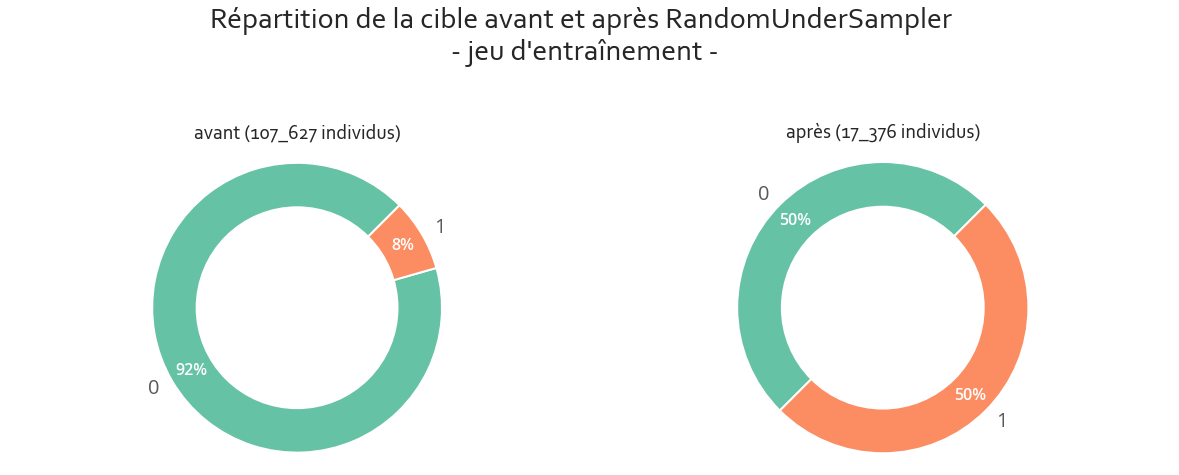

In [144]:
toolbox.compare_donuts(y_train, resampled_data[1], 'TARGET',
                       'Répartition de la cible avant et après RandomUnderSampler\n - jeu d\'entraînement -',
                       (17, 7), top=0.7, wspace=0.01)

In [145]:
del resampled_data, transformed_data, pipeline, preprocessor, transformed_data_df

In [146]:
gc.collect()

86952

<h4 style="font-family:Corbel Light; color:#737373">Score métier</h4>

Pour choisir et optimiser le meilleur modèle de classification, nous allons, entre autres, chercher à minimiser un score métier.

Ce score métier doit prendre en compte le fait que classer un "mauvais" client en "bon" client entraîne une perte en capital 10 fois plus grande que le manque à gagner en marge dû au fait de classer un "bon" client en "mauvais" client.

Ce score métier sera calculé, en optimisant le seuil au dessus duquel un individu appartient à la classe 1.


Pour chaque valeur de seuil testée, nous allons:
- remplacer la probabilité d'appartenir à la classe 1 en label 1 si la proba > seuil et en label 0 sinon
- calculer un score métier avec ces labels


Puis garder le seuil qui minimise le score métier et l'utiliser pour faire des prédictions sur de nouvelles données.

*Rappel: classe 0 = "bon" client, classe 1 = "mauvais" client*

In [15]:
def cost(y_true: pd.DataFrame, y_pred: np.array):
    """
    Renvoie le coût métier, tq Coût FN = 10*Coût FP

    Positional arguments : 
    -------------------------------------
    y_true : pd.DataFrame : cibles à prédire
    y_pred : np.array : pour chaque individu [probabilité prédite d'appartenir à la classe 0, 
                                              probabilité prédite d'appartenir à la classe 1]
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,
                                      labels=[0, 1],
                                      normalize='all').ravel()
    total_cost = (10*fn + fp)/10

    return total_cost

In [16]:
def custom_cost_score(y_true: pd.DataFrame, y_pred_positive_proba: np.array, return_thresh=False):
    """
    Renvoie le score métier et le seuil optimisé qui détermine la classe 0 ou 1

    Positional arguments : 
    -------------------------------------
    y_true : pd.DataFrame : cibles à prédire
    y_pred_positive_proba : np.array : probabilité prédite d'appartenir à la classe 1, pour chaque individu.

    Optional arguments : 
    -------------------------------------
    return_thresh : bool : renvoyer, ou pas, le seuil au dessus duquel un individu est classé dans la classe 1.
    """
    scores = []
    thresholds = np.arange(0, 1, 0.001)
    for thresh in thresholds:
        y_pred_labels = (y_pred_positive_proba >= thresh).astype('int')
        scores.append(cost(y_true, y_pred_labels))

    best_thresh_index = np.argmin(scores)

    if return_thresh:
        return scores[best_thresh_index], thresholds[best_thresh_index]

    return scores[best_thresh_index]

Vérifions que la fonction de coût métier fonctionne 

In [ ]:
y_pred_p = pipeline.predict_proba(X_test)
y_pred_p

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [126]:
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [127]:
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[84805,     0],
       [ 7448,     0]], dtype=int64)

On a bien dans l'ordre : tn, fp, fn, tp

In [129]:
confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()

array([84805,     0,  7448,     0], dtype=int64)

In [130]:
confusion_matrix(y_test, y_pred, labels=[0,1], normalize='all')

array([[0.9192655, 0.       ],
       [0.0807345, 0.       ]])

In [134]:
cost(y_test, y_pred)

0.08073450185901813

In [142]:
custom_cost_score(y_test, y_pred_p[:,1])

0.08073450185901813

<h3 style="font-family:Corbel Light; color:#737373">Modélisation</h3>

In [31]:
results_dir = 'results'
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

Emplacement du dossier dans lequel les infos (scores, params, nom modèle ...) sont enregistrées par MLFlow tracking: 

In [ ]:
mlflow.tracking.get_tracking_uri()

Transformations à mettre dans le pipeline: 

In [39]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in X_train.columns
                  if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

In [18]:
transformers_features = [{'feature': binary_features,
                          'estimator': [OrdinalEncoder(dtype=int)]},
                         {'feature': categ_features,
                          'estimator': [toolbox.GetDummiesTransformer()]},
                         {'feature': numeric_features,
                          'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                         ]

sampler = [RandomUnderSampler(random_state=8)]

<h4 style="font-family:Corbel Light; color:#737373">Modèles Linéaires + Base</h4>

Commençons par tester un modèle naïf qui prédit toujours la classe 0. Les autres modèles devront obtenir faire mieux. 
Testons également un modèle linéaire : la régression logistique.

In [76]:
classifiers_base = [
    {'name': 'dummy',
     'classifier': DummyClassifier(),
     'params': {'dummyclassifier__strategy': (['most_frequent'])}
     },
    {'name': 'logistic_reg',
     'classifier': LogisticRegression(),
     'params': {'logisticregression__C': ([0.01, 0.1, 1, 10, 100]),
                'logisticregression__solver': (['sag', 'saga'])}
     }
]

In [78]:
%%time
scores_cv_base, scores_test_base = toolbox.grid_search_cv_and_score(classifiers_base,
                                                                    X_train, y_train.values.ravel(),
                                                                    X_test, y_test.values.ravel(),
                                                                    transformers_features,
                                                                    sampler, n_splits=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hermine\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

CPU times: total: 51min 34s
Wall time: 1h 1min 26s


*Rmq : Svm prend trop de temps a être entrainé.*

<h4 style="font-family:Corbel Light; color:#737373">Modèles Ensemblistes</h4>

Testons maintenant quelques modèles ensemblistes:
- Bagging
- Forêt Aléatoire
- Adaboost
- GBoost

In [91]:
classifiers_ensemble = [
    {'name': 'bagging',
     'classifier': BaggingClassifier(random_state=8),
     'params': {'baggingclassifier__n_estimators': ([10, 50, 100]),
                # 'baggingclassifier__max_features': ([1, 0.5, 0.8]),
                # 'baggingclassifier__bootstrap': ([True, False]),
                # 'baggingclassifier__bootstrap_features': ([True, False])
                }
     },
    {'name': 'random_forest',
     'classifier': RandomForestClassifier(random_state=8),
     'params': {'randomforestclassifier__n_estimators': ([100, 300]),
                # 'randomforestclassifier__max_depth': ([2, 5, 10]),
                'randomforestclassifier__max_features': ([None, 'sqrt', 'log2']),
                # 'randomforestclassifier__class_weight': (['balanced', None]),
                }
     },
    {'name': 'adaboost',
     'classifier': AdaBoostClassifier(random_state=8),
     'params': {'adaboostclassifier__n_estimators': ([50, 100]),
                'adaboostclassifier__learning_rate': ([0.1, 1]),
                'adaboostclassifier__algorithm': (['SAMME', 'SAMME.R']),
                }
     },
    {'name': 'gboost',
     'classifier': GradientBoostingClassifier(random_state=8),
     'params': {'gradientboostingclassifier__n_estimators': ([100, 300]),
                'gradientboostingclassifier__max_depth': ([3, 6]),
                'gradientboostingclassifier__learning_rate': ([0.01, 0.1, 1]),
                # 'gradientboostingclassifier__subsample': ([0.5, 0.7, 1]),
                # 'gradientboostingclassifier__max_features': ([1, 0.5, 0.8]),
                # 'gradientboostingclassifier__min_samples_leaf': ([2, 5]),
                # 'gradientboostingclassifier__min_samples_split': ([2, 5]),
                }
     }
]

In [ ]:
%%time
scores_cv_ensemble, scores_test_ensemble = toolbox.grid_search_cv_and_score(classifiers_ensemble, X_train, y_train.values.ravel(),
                                                                            X_test, y_test.values.ravel(),
                                                                            transformers_features,
                                                                            sampler, n_splits=3)

In [ ]:
scores_cv = pd.concat([scores_cv_base, scores_cv_ensemble], ignore_index=True)
scores_test = pd.concat([scores_test_base,
                         scores_test_ensemble],
                        ignore_index=True)

scores_cv.to_pickle(results_dir + '/Scores_cv.pkl')
scores_test.to_pickle(results_dir + '/Scores_test.pkl')

<h4 style="font-family:Corbel Light; color:#737373">Modèles qui gèrent les valeurs manquantes</h4>

Puis, testons des modèles ensemblistes qui gèrent seuls les valeurs manquantes (donc pas besoin de les imputer par la médiane):
- XGBoost
- LightGBM
- CatBoost

In [57]:
transformers_features_nan = [{'feature': binary_features,
                              'estimator': [OrdinalEncoder(dtype=int)]},
                             {'feature': categ_features,
                              'estimator': [toolbox.GetDummiesTransformer()]},
                             {'feature': numeric_features,
                              'estimator': [RobustScaler()]}
                             ]

classifiers_handle_nan = [
    {'name': 'xgboost',
     'classifier': XGBClassifier(seed=8),
     'params': {'xgbclassifier__eta': ([0.01, 0.1, 1]),
                'xgbclassifier__max_depth': ([3, 6]),
                # 'xgbclassifier__colsample_bytree': ([0.4, 1]),
                # 'xgbclassifier__gamma': ([0, 0.1]),
                # 'xgbclassifier__reg_lambda': ([1, 10, 50]),
                'xgbclassifier__n_estimators': ([100, 500, 1_000]),
                # 'xgbclassifier__subsample': ([1, 0.5, 0.8]),
                }
     },
    {'name': 'lgbm',
     'classifier': LGBMClassifier(random_state=8),
     'params': {'lgbmclassifier__learning_rate': ([0.01, 0.1, 1]),
                'lgbmclassifier__n_estimators': ([100, 500, 1_000]),
                'lgbmclassifier__max_depth': ([3, 6]),
                # 'lgbmclassifier__num_leaves': ([34]),
                # 'lgbmclassifier__colsample_bytree': ([.5, 0.8, 1]),
                # 'lgbmclassifier__subsample': ([0.8, 0.2]),
                # 'lgbmclassifier__reg_alpha': ([0.04, 0]),
                # 'lgbmclassifier__min_split_gain': ([0.02]),
                # 'lgbmclassifier__reg_lambda': ([0.07, 0]),
                # 'lgbmclassifier__min_child_weight': ([39]),
                }
     }
]

In [ ]:
%%time
scores_cv_handle_nan, scores_test_handle_nan = toolbox.grid_search_cv_and_score(classifiers_handle_nan,
                                                                                X_train, y_train.values.ravel(),
                                                                                X_test, y_test.values.ravel(),
                                                                                transformers_features_nan,
                                                                                transformers_dataset, n_splits=3)

Rmq : Pour catboost, il faut remplacer les np.nan (float) par des "NaN" (string) afin que le modèle puisse correctement traiter les valeurs manquantes dans les variables catégorielles. On le laisse choisir les transformations à appliquer.

In [ ]:
set_config(transform_output="pandas")
cat_features = [*binary_features, *categ_features]
cat_features_pipeline = ['pipeline__' + feature for feature in cat_features]
transformers_features_cat = [{'feature': cat_features,
                              'estimator': [SimpleImputer(missing_values=np.nan, fill_value="NaN", strategy='constant')]}]

catboost = [
    {'name': 'catboost',
     'classifier': ctb.CatBoostClassifier(cat_features=cat_features_pipeline, random_seed=8),
     'params': {'catboostclassifier__learning_rate': ([0.01, 0.1, 1]),
                'catboostclassifier__iterations': ([100, 500, 1_000]),
                # 'catboostclassifier__l2_leaf_reg': ([0.4, 1]),
                # 'catboostclassifier__subsample': ([1, 0.5, 0.8]),
                'catboostclassifier__depth': ([3, 6]),
                # 'catboostclassifier__ignored_features': ([100, 500, 1_000]),
                # 'catboostclassifier__max_leaves': ([1, 0.5, 0.8]),
                # 'catboostclassifier__auto_class_weights': ([None, 'Balanced', 'SqrtBalanced']),
                }
     }
]

In [ ]:
scores_cv_catboost, scores_test_catboost = toolbox.grid_search_cv_and_score(catboost,
                                                                            X_train, y_train.values.ravel(),
                                                                            X_test, y_test.values.ravel(),
                                                                            transformers_features_cat,
                                                                            transformers_dataset, n_splits=3)

In [ ]:
scores_cv = pd.concat([scores_cv, scores_cv_catboost], ignore_index=True)
scores_test = pd.concat([scores_test, scores_test_catboost], ignore_index=True)

scores_cv.to_pickle(results_dir + '/Scores_cv.pkl')
scores_test.to_pickle(results_dir + '/Scores_test.pkl')

<h4 style="font-family:Corbel Light; color:#737373">Modèles ImbLearn</h4>

Enfin, par curiosité, testons quelques modèles fournis par la librairie ImbLearn qui intégrent le sampling.
- Random Forest
- GBoost

In [98]:
sklearn.utils.parallel.Parallel()

In [92]:
classifiers_brdnf = [
    {'name': 'balanced_random_forest',
     'classifier': BalancedRandomForestClassifier(random_state=8),
     'params': {  # 'balancedrandomforestclassifier__class_weight': (['balanced', None, 'balanced_subsample']),
         # 'balancedrandomforestclassifier__n_estimators': ([100, 500, 1_000]),
         # 'balancedrandomforestclassifier__max_depth': ([2, 5, 10]),
         # 'balancedrandomforestclassifier__max_features': ([None, 0.5, 0.8]),
         'balancedrandomforestclassifier__n_estimators': ([100])
     }
     }
]

In [93]:
classifiers_rusboost = [
    {'name': 'rusboost',
     'classifier': RUSBoostClassifier(random_state=8),
     'params': {  # 'rusboostclassifier__n_estimators': ([10, 50, 100]),
         # 'rusboostclassifier__learning_rate': ([1.0, 0.5, 0.1]),
         # 'rusboostclassifier__algorithm': (['SAMME', 'SAMME.R']),
         'rusboostclassifier__n_estimators': ([100])
     }
     }
]

In [ ]:
%%time
scores_cv_rusboost, scores_test_rusboost = toolbox.grid_search_cv_and_score(classifiers_rusboost,
                                                                            X_train, y_train.values.ravel(),
                                                                            X_test, y_test.values.ravel(),
                                                                            transformers_features,
                                                                            n_splits=3)

2023/06/07 20:23:57 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
          ...`


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
scores_cv = pd.concat([scores_cv, scores_cv_rusboost], ignore_index=True)
scores_test = pd.concat([scores_test, scores_cv_rusboost], ignore_index=True)

scores_cv.to_pickle(results_dir + '/Scores_cv.pkl')
scores_test.to_pickle(results_dir + '/Scores_test.pkl')

<h4 style="font-family:Corbel Light; color:#737373">Résultats</h4>

In [39]:
scores_cv = pd.read_pickle(results_dir + '/Scores_cv.pkl')
scores_test = pd.read_pickle(results_dir + '/Scores_test.pkl')

Résultats jeu de validation :

In [40]:
scores_cv_test = scores_cv.loc[scores_cv['set'] == 'test']
scores_cv_test.sort_values(['mean_custom_score', "mean_balanced_accuracy",
                           'mean_time_fit'], ascending=[False, False, True])

,model,set,params,mean_time_fit,std_time_fit,mean_custom_score,std_custom_score,mean_accuracy,std_accuracy,mean_balanced_accuracy,std_balanced_accuracy,mean_recall,std_recall,mean_precision,std_precision,mean_roc_auc,std_roc_auc
16,lgbm,test,{'lgbmclassifier__n_estimators': 100},23.032299,14.997249,-0.052362,0.000558,0.693571,0.001727,0.694582,0.004403,0.695787,0.008069,0.166155,0.001990,0.694582,0.004403
10,gboost,test,{'gradientboostingclassifier__n_estimators': 100},194.304412,9.847859,-0.052436,0.000705,0.691044,0.001635,0.694467,0.003531,0.698550,0.008127,0.165357,0.001285,0.694467,0.003531
14,catboost,test,{'catboostclassifier__iterations': 100},65.841977,14.178486,-0.053460,0.000420,0.685116,0.001782,0.685993,0.003257,0.687040,0.008085,0.160714,0.001072,0.685993,0.003257
6,random_forest,test,"{'randomforestclassifier__max_features': None,...",2595.979300,82.167899,-0.054186,0.000915,0.685925,0.002912,0.682968,0.004774,0.679443,0.009262,0.159888,0.002170,0.682968,0.004774
4,bagging,test,{'baggingclassifier__n_estimators': 100},859.917908,7.087557,-0.054766,0.000774,0.687411,0.001568,0.679472,0.004363,0.670005,0.009939,0.159051,0.001559,0.679472,0.004363
12,xgboost,test,{'xgbclassifier__n_estimators': 100},88.230552,18.785044,-0.055148,0.000086,0.680740,0.000410,0.677839,0.001195,0.674378,0.002238,0.156695,0.000508,0.677839,0.001195
18,balanced_random_forest,test,{'balancedrandomforestclassifier__n_estimators...,53.316483,11.193479,-0.055821,0.000568,0.686779,0.001520,0.674036,0.002625,0.658840,0.008069,0.156945,0.000928,0.674036,0.002625
8,adaboost,test,"{'adaboostclassifier__algorithm': 'SAMME.R', '...",530.700000,3.851000,-0.056000,0.000844,0.904000,0.001000,0.558000,0.003000,0.146000,0.007000,0.304000,0.010000,0.558000,0.003000
2,logistic_reg,test,"{'logisticregression__C': 0.1, 'logisticregres...",31.776058,0.162462,-0.077900,0.000415,0.542633,0.016003,0.537891,0.006581,0.532234,0.022409,0.092903,0.002206,0.537891,0.006581
0,dummy,test,{'dummyclassifier__strategy': 'most_frequent'},59.774185,62.601783,-0.080723,0.000022,0.919277,0.000022,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000


Résultats jeu d'entrainement :

In [41]:
scores_cv_train = scores_cv.loc[scores_cv['set'] == 'train']
scores_cv_train.sort_values(['mean_custom_score', "mean_balanced_accuracy",
                            'mean_time_fit'], ascending=[False, False, True])

,model,set,params,mean_time_fit,std_time_fit,mean_custom_score,std_custom_score,mean_accuracy,std_accuracy,mean_balanced_accuracy,std_balanced_accuracy,mean_recall,std_recall,mean_precision,std_precision,mean_roc_auc,std_roc_auc
19,balanced_random_forest,train,{'balancedrandomforestclassifier__n_estimators...,53.316483,11.193479,-0.002423,0.000062,0.778884,0.001427,0.879734,0.000776,1.000000,0.000000,0.267444,0.001265,0.879734,0.000776
7,random_forest,train,"{'randomforestclassifier__max_features': None,...",2595.979300,82.167899,-0.007661,0.000110,0.737696,0.001774,0.857331,0.000965,1.000000,0.000000,0.235332,0.001213,0.857331,0.000965
5,bagging,train,{'baggingclassifier__n_estimators': 100},859.917908,7.087557,-0.008787,0.000145,0.740156,0.002724,0.858669,0.001482,1.000000,0.000000,0.237041,0.001900,0.858669,0.001482
13,xgboost,train,{'xgbclassifier__n_estimators': 100},88.230552,18.785044,-0.026872,0.006283,0.722412,0.005726,0.826864,0.024678,0.951427,0.047332,0.219088,0.009724,0.826864,0.024678
17,lgbm,train,{'lgbmclassifier__n_estimators': 100},23.032299,14.997249,-0.034505,0.000558,0.724028,0.000676,0.797663,0.001373,0.885474,0.003465,0.211346,0.000384,0.797663,0.001373
15,catboost,train,{'catboostclassifier__iterations': 100},65.841977,14.178486,-0.040503,0.000356,0.707996,0.003033,0.764243,0.001142,0.831319,0.005176,0.194245,0.001098,0.764243,0.001142
11,gboost,train,{'gradientboostingclassifier__n_estimators': 100},194.304412,9.847859,-0.047812,0.000400,0.699829,0.003125,0.722370,0.001856,0.749252,0.000776,0.177688,0.001668,0.722370,0.001856
9,adaboost,train,"{'adaboostclassifier__algorithm': 'SAMME.R', '...",530.700000,3.851000,-0.054000,0.000392,0.905000,0.000962,0.562000,0.003000,0.153000,0.008000,0.321000,0.003000,0.562000,0.003000
3,logistic_reg,train,"{'logisticregression__C': 0.1, 'logisticregres...",31.776058,0.162462,-0.078107,0.000204,0.543031,0.013435,0.537342,0.001685,0.530559,0.012792,0.092751,0.000912,0.537342,0.001685
1,dummy,train,{'dummyclassifier__strategy': 'most_frequent'},59.774185,62.601783,-0.080723,0.000005,0.919277,0.000005,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000


Résultats jeu de test:

LightGBM et GBoost ont les meilleurs résultats sur le score métier et la balanced accuracy.

In [42]:
scores_test.sort_values(['custom_score', "balanced_accuracy_score"],
                        ascending=[True, False])

,model,threshold,custom_score,accuracy_score,balanced_accuracy_score,roc_auc_score
8,lgbm,0.547,0.050655,0.742813,0.703593,0.703593
5,gboost,0.533,0.050815,0.735355,0.703211,0.703211
7,catboost,0.523,0.052346,0.717708,0.695082,0.695082
6,xgboost,0.619,0.054056,0.770650,0.679910,0.679910
4,adaboost,0.496,0.054381,0.682327,0.685268,0.685268
2,bagging,0.690,0.062273,0.872089,0.619838,0.619838
3,random_forest,0.694,0.062936,0.874626,0.615461,0.615461
9,balanced_random_forest,0.690,0.069696,0.900490,0.570865,0.570865
1,logistic_reg,0.506,0.077481,0.866149,0.524875,0.524875
0,dummy,0.001,0.080735,0.919265,0.500000,0.500000


Regardons le score métier obtenus par validation croisée sur les jeux d'entrainement et de validation:

On cherche à minimiser ce score métier qui reflète le coût engendré par de mauvaises prédictions.

Le modèle naïf et la régression linéaire ont les scores métiers les plus élevés, tant à l'entrainement qu'à la validation.
Les modèles bagging et forêt aléatoire souffrent d'un fort surapprentissage (ils sont très bons à l'entrainement mais très mauvais à la validation).

Les modèles AdaBoost et GBoost surapprennent peu et ont de meilleurs résultats, Gboost ayant un score métier un peu plus faible que AdaBoost. 

Parmi les modèles qui gèrent les valeurs manquantes (XGBoost, CatBoost et LightGBM), lightGBM a le score métier le plus faible mais CatBoost surapprend moins.  XGboost est celui qui surapprend le plus et a le score métier le plus élevé.

Au vu de ces résultats, on pourrait retenir les modèles AdaBoost, GBoost, CatBoost et LightGBM comme candidats à l'optimisation.

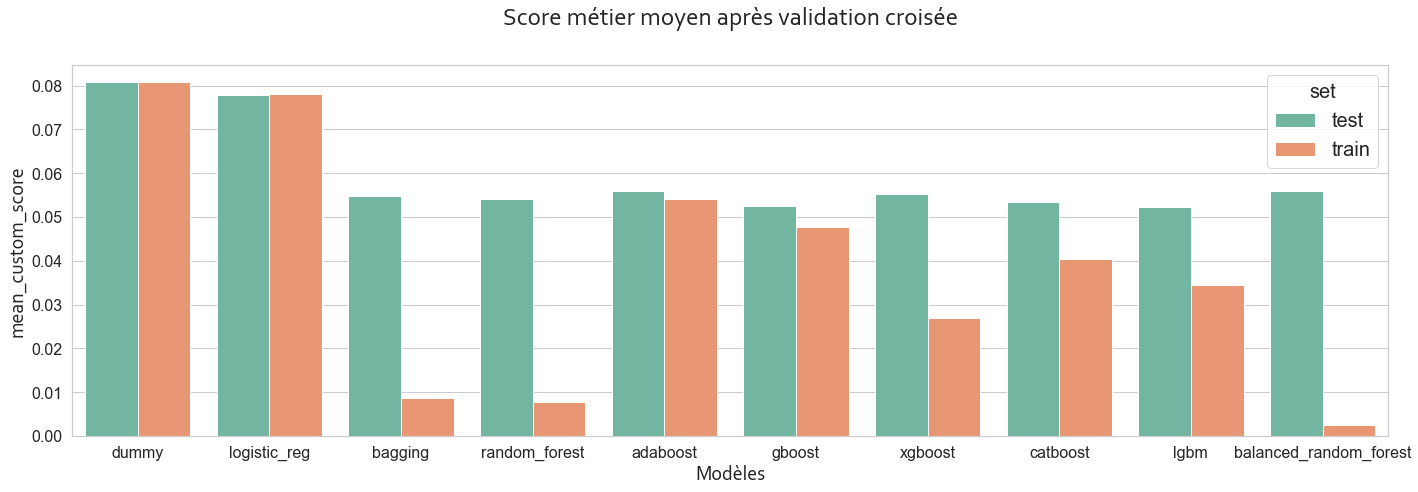

In [46]:
scores_copy = scores_cv.copy()
scores_copy['mean_custom_score'] = scores_copy['mean_custom_score'].abs()
titles = {"title": 'Score métier moyen après validation croisée',
          "xlabel": 'Modèles'}

toolbox.display_barplot(scores_copy, 'model',
                        'mean_custom_score', titles,
                        (20, 7), 'set', True, 'Set2'
                        )

Regardons la Balanced Accuracy moyenne après validation: On cherche à maximiser ce score.

De nouveau, les modèles Bagging et Forêt aléatoire sont ceux qui surapprennent le plus. 

GBoost a de meilleurs résultats que AdaBoost (mais surapprend plus). 

Parmi les modèles qui gèrent les valeurs manquantes, XGBoost est celui qui souffre le plus du surapprentissage. Lightgbm et catboost ont des résultats similaires sur le jeu de validation mais lightgbm surapprend un peu plus.

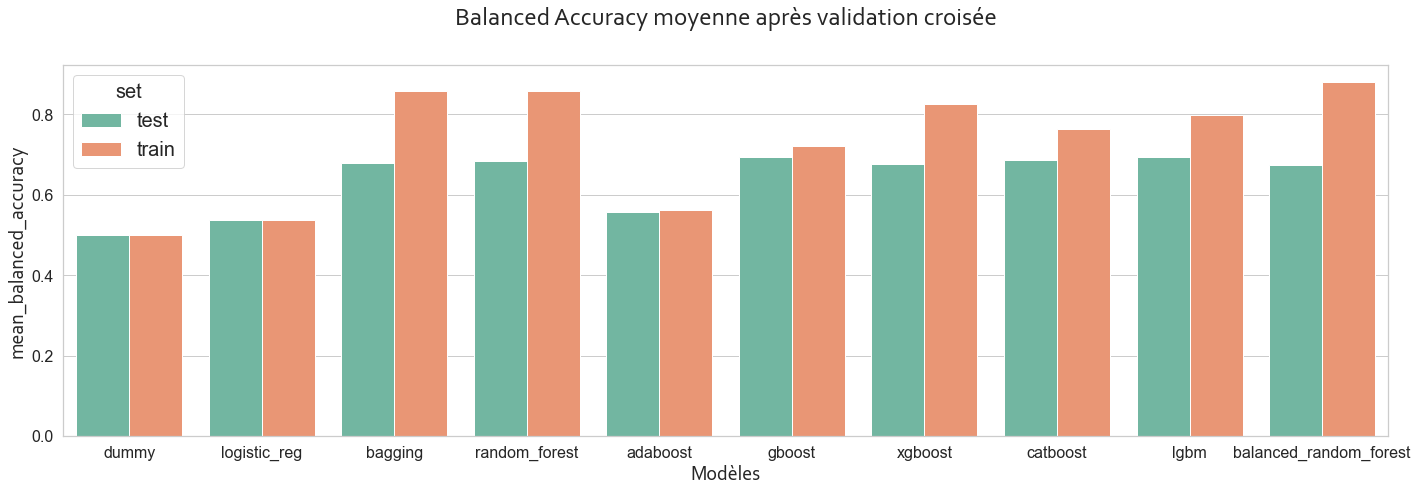

In [47]:
titles = {"title": 'Balanced Accuracy moyenne après validation croisée',
          'xlabel': 'Modèles'}

toolbox.display_barplot(scores_copy, 'model',
                        'mean_balanced_accuracy', titles,
                        (20, 7), 'set', True, 'Set2'
                        )

Regardons le temps d'entrainement moyen de ces différents modèles :

La forêt aléatoire classique est le modèle qui prend le plus de temps à être entrainé. 

GBoost est plus rapide que AdaBoost. 

LightGBM semble le plus rapide, ce qui nous conforte dans l'idée de choisir ce modèle.

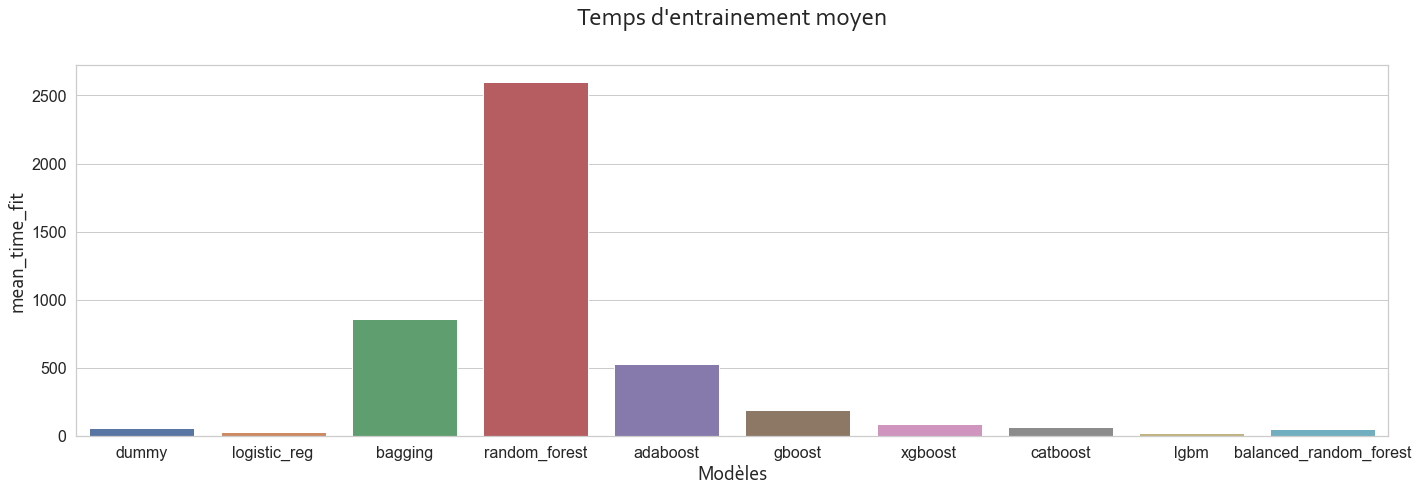

In [45]:
titles = {'title': 'Temps d\'entrainement moyen', 'xlabel': 'Modèles'}
toolbox.display_barplot(scores_copy, 'model', 'mean_time_fit', titles, (20, 7))

<h3 style="font-family:Corbel Light; color:#737373">Optimisation</h3>

Nous allons chercher à optimiser les hyperparamètres des modèles GBoost et LightGBM, avec la librairie hyperopt, afin de limiter leur surapprentissage. Nous retiendrons le modèle avec les meilleurs résultats.

In [22]:
datasets = {'X_train': X_train,
            'y_train': y_train.values.ravel(),
            'X_test': X_test,
            'y_test': y_test.values.ravel()}

In [147]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in X_train.columns
                  if X_train[col].dtype == 'object' and col not in binary_features]
numeric_features = X_train._get_numeric_data().columns

<h4 style="font-family:Corbel Light; color:#737373">Gradient Boost</h4>

In [148]:
transformers_features = [{'feature': binary_features,
                          'estimator': [OrdinalEncoder(dtype=int)]},
                         {'feature': categ_features,
                          'estimator': [toolbox.GetDummiesTransformer()]},
                         {'feature': numeric_features,
                          'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                         ]

sampler = [RandomUnderSampler(random_state=8)]

In [27]:
space_gb = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
            'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
            'max_features': hp.quniform('max_features', 0.5, 1.0, 0.1),
            # 'n_iter_no_change' : scope.int(hp.quniform('n_iter_no_change', 5, 100, 1)),
            'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 2, 5, 1)),
            'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 5, 1))
            }

In [28]:
%%time
trials_gb = Trials()
best_params_gb = fmin(fn=partial(toolbox.gb_cv, X=X_train, y=y_train, transformers=transformers_features, sampler=sampler),
                      space=space_gb,
                      algo=tpe.suggest,
                      max_evals=5,
                      trials=trials_gb,
                      rstate=np.random.default_rng(8),
                      # early_stop_fn=no_progress_loss(20)
                      )

100%|██████████| 5/5 [1:43:19<00:00, 1239.87s/trial, best loss: 0.054082150532955876]
CPU times: total: 18.4 s
Wall time: 1h 43min 26s


In [52]:
best_model_gb = GradientBoostingClassifier(random_state=8, n_iter_no_change=5,
                                           n_estimators=int(best_params_gb['n_estimators']),
                                           max_depth=int(best_params_gb['max_depth']),
                                           learning_rate=best_params_gb['learning_rate'],
                                           max_features=best_params_gb['max_features'],
                                           # n_iter_no_change=int(best_params_gb['n_iter_no_change']),
                                           min_samples_leaf=int(best_params_gb['min_samples_leaf']),
                                           min_samples_split=int(best_params_gb['min_samples_split'])
                                           )

best_model_gb_fit, best_params_gb_df = toolbox.score_best_model(best_model_gb,
                                                                transformers_features,
                                                                best_params_gb,
                                                                datasets, sampler)

,Param,Best Param
0,learning_rate,0.205795
1,max_depth,5.000000
2,max_features,0.900000
3,min_samples_leaf,5.000000
4,min_samples_split,3.000000
5,n_estimators,311.000000
0,thresh,0.535000


Modèle optimisé : 
Test Score métier : 0.0515
Temps d'entrainement : 173.443
Train Score métier : 0.0434


<h4 style="font-family:Corbel Light; color:#737373">LightGBM</h4>

In [149]:
transformers_features_nan = [{'feature': binary_features,
                              'estimator': [OrdinalEncoder(dtype=int)]},
                             {'feature': categ_features,
                              'estimator': [toolbox.GetDummiesTransformer()]},
                             {'feature': numeric_features,
                              'estimator': [RobustScaler()]}
                             ]
sampler = [RandomUnderSampler(random_state=8)]

In [46]:
space_lgbm = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 1)),
              'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
              'num_leaves': scope.int(hp.quniform('num_leaves', 2, 40, 1)),
              'learning_rate': hp.loguniform('learning_rate',  np.log(0.1), np.log(0.7)),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
              'subsample': hp.uniform('subsample', 0.5, 1.0),
              'reg_alpha': hp.uniform('reg_alpha', 0, 100),
              'reg_lambda': hp.uniform('reg_lambda', 0, 100),
              'min_split_gain': hp.uniform('min_split_gain', 0.5, 1.0),
              'min_child_weight': hp.uniform('min_child_weight', 0.5, 1.0),
              }

In [51]:
%%time
trials_lgbm = Trials()
best_params_lgbm = fmin(fn=partial(toolbox.lgbm_cv, X=X_train, y=y_train, transformers=transformers_features_nan, sampler=sampler),
                        space=space_lgbm,
                        algo=tpe.suggest,
                        max_evals=30,
                        trials=trials_lgbm,
                        rstate=np.random.default_rng(8),
                        # early_stop_fn=no_progress_loss(20)
                        )

 77%|███████▋  | 23/30 [1:37:42<37:18, 319.81s/trial, best loss: 0.05152796136492336]  

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



100%|██████████| 30/30 [2:04:43<00:00, 249.45s/trial, best loss: 0.05152796136492336]
CPU times: total: 1min 17s
Wall time: 2h 4min 45s


In [52]:
trials_df_lgbm = toolbox.build_trial_df(trials_lgbm, 'custom_score')
trials_df_lgbm.head()

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_gain,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample,custom_score,trial_number
0,0.574753,0.130866,3.0,0.580024,0.685442,499.0,35.0,93.907929,16.719938,0.763658,0.055017,0
1,0.857649,0.358596,5.0,0.601123,0.942414,346.0,39.0,16.816294,59.156873,0.644271,0.052383,1
2,0.832663,0.189914,4.0,0.762043,0.925481,322.0,27.0,32.270227,94.101465,0.824666,0.052864,2
3,0.793453,0.173670,3.0,0.840205,0.852331,226.0,26.0,97.325495,35.792373,0.866214,0.055541,3
4,0.520425,0.277999,8.0,0.994972,0.884234,324.0,25.0,61.003708,69.380290,0.653708,0.053654,4


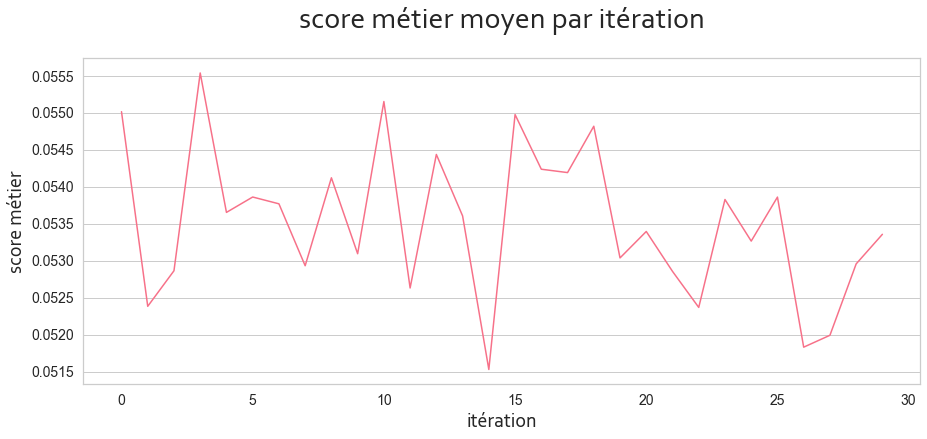

In [55]:
titles = {'title': 'score métier moyen par itération',
          'xlabel': 'itération', 'ylabel': 'score métier'}

toolbox.display_lineplot(trials_df_lgbm, 'trial_number',
                         'custom_score', (15, 6),
                         titles, grid_x=False
                         )

In [78]:
best_model_lgbm = LGBMClassifier(random_state=8,
                                 n_estimators=int(best_params_lgbm['n_estimators']),
                                 max_depth=int(best_params_lgbm['max_depth']),
                                 learning_rate=best_params_lgbm['learning_rate'],
                                 colsample_bytree=best_params_lgbm['colsample_bytree'],
                                 subsample=best_params_lgbm['subsample'],
                                 reg_alpha=best_params_lgbm['reg_alpha'],
                                 reg_lambda=best_params_lgbm['reg_lambda'],
                                 min_split_gain=best_params_lgbm['min_split_gain'],
                                 min_child_weight=best_params_lgbm['min_child_weight'],
                                 num_leaves=int(best_params_lgbm['num_leaves'])
                                 )

best_model_lgbm_fit, best_params_lgbm_df = toolbox.score_best_model(best_model_lgbm,
                                                                    transformers_features_nan,
                                                                    best_params_lgbm,
                                                                    datasets, sampler, True
                                                                    )

,Param,Best Param
0,colsample_bytree,0.884904
1,learning_rate,0.349338
2,max_depth,7.000000
3,min_child_weight,0.927633
4,min_split_gain,0.594755
5,n_estimators,425.000000
6,num_leaves,3.000000
7,reg_alpha,2.028504
8,reg_lambda,98.164184
9,subsample,0.775639


Modèle optimisé : 
Test Score métier : 0.0499
Test AUC: 0.7088
Temps d'entrainement : 31.427
Train Score métier : 0.0461


Nous allons utiliser le modèle lightGBM pour faire notre classification. Sauvegardons ses meilleurs hyperparamètres:

In [ ]:
best_params_lgbm_df.to_pickle(results_dir + '/BestParams.pkl')

Nous pouvons également tracer la courbe ROC pour ce modèle:

Cette courbe montre, pour chaque seuil de décision, comment la sensibilité évolue en fonction de l'anti-spécificité. Plus on s'éloigne de la première bissectrice (modèle aléatoire) mieux c'est. 

In [279]:
y_pred_proba = best_model_lgbm_fit.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

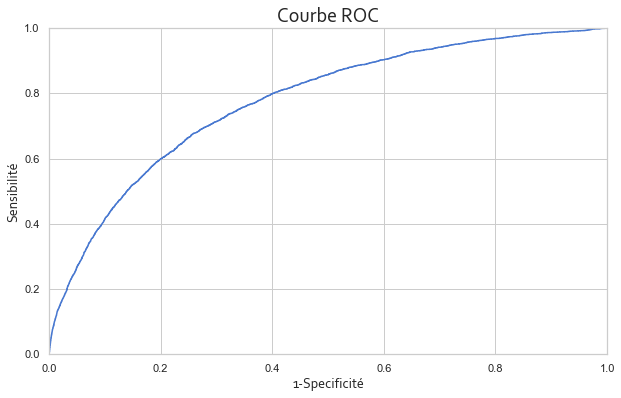

In [288]:
toolbox.display_roc_curve(fpr, tpr)

<h4 style="font-family:Corbel Light; color:#737373">Analyse importance des variables</h4>

Regardons quelles variables sont les plus utilisées par les modèles GBoost et LightGBM:

In [99]:
binary_features =  best_model_lgbm_fit[0].named_transformers_['pipeline-1'][0].feature_names_in_
numeric_features =  best_model_lgbm_fit[0].named_transformers_['pipeline-3'][0].feature_names_in_
features_getdummies = best_model_lgbm_fit[0].named_transformers_['pipeline-2'][0].get_feature_names()

features_final = [*binary_features, *features_getdummies, *numeric_features]

In [152]:
tree_models = []

classifiers = [{'name': 'gboost',
                'classifier': best_model_gb,
                'transformers': transformers_features, 
                'x_label': 'Gini importance'},
               {'name': 'lgbm',
                'classifier': best_model_lgbm,
                'transformers': transformers_features_nan, 
                'x_label': 'Nombre de fois que la variable est utilisée par le modèle'
                }
               ]

for model in classifiers:
    clf = toolbox.build_model(model['classifier'], model['transformers'], sampler)
    clf.fit(X_train, y_train.values.ravel())

    tree_models.append({"name": model['name'], "model": clf, "x_label": model['x_label']})

<Figure size 1656x720 with 0 Axes>

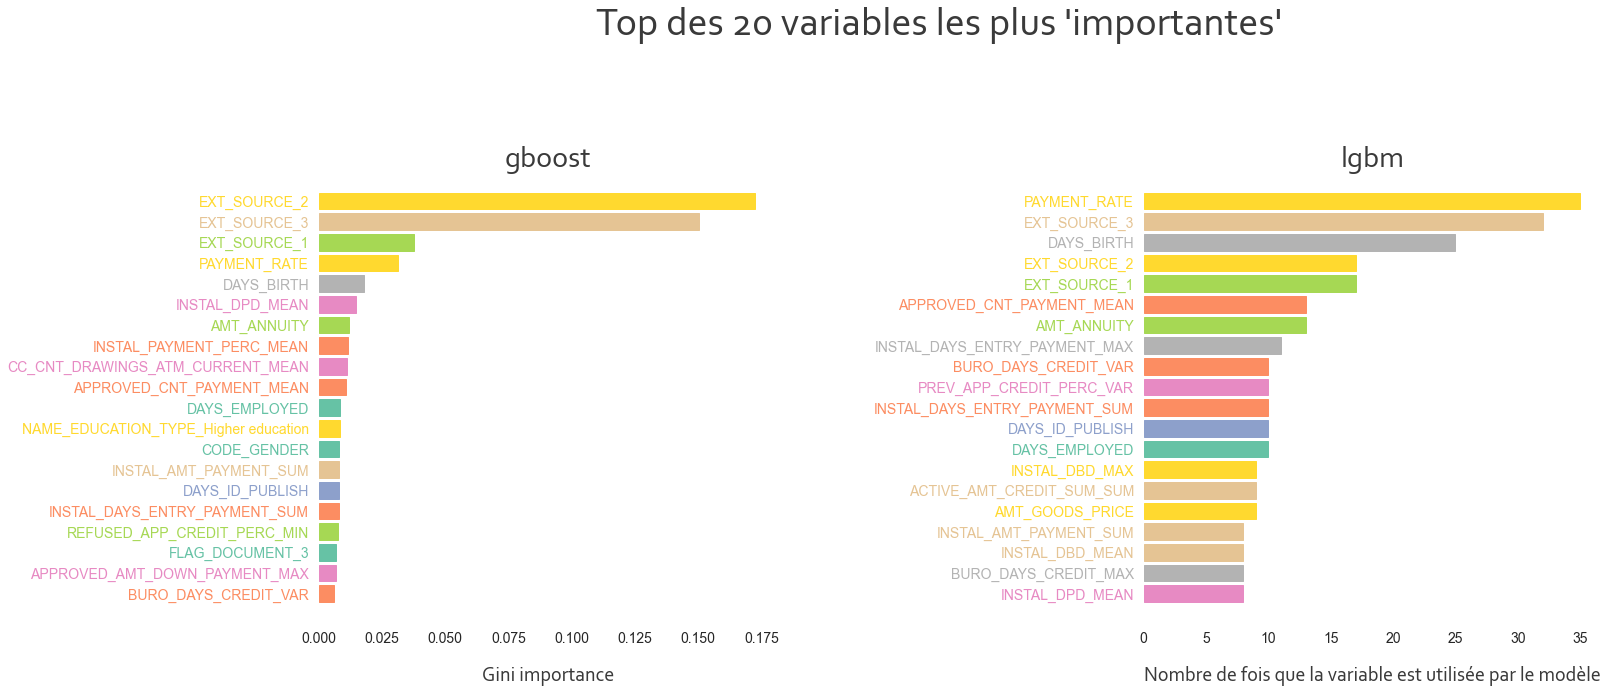

In [181]:
toolbox.plot_feature_importance_tree_model(tree_models,
                                           features_final,
                                           (23, 10), 20, top=0.75, palette='Set2')

Les modèles utilisent essentiellement:
- les notes attribuées aux clients par d'autres institutions financières (EXT_SOURCE). Ces notes sont normalisées entre 0 et 1, mais nous n'avons pas plus de détail sur leur source, ni sur la façon dont elles ont été calculées.
- le taux de remboursement, variable ajoutée lors du feature engineering (montant des annuités/montant du crédit)
- l'âge de l'emprunteur

Regardons si certaines features ne sont pas utilisées par le modèle LGBM: 

In [186]:
feature_importance = tree_models[1]["model"][-1].feature_importances_
feature_imp_df = pd.DataFrame(feature_importance, columns=["Split"])
feature_imp_df['Feature Name'] = features_final
features_used = feature_imp_df.loc[feature_imp_df['Split']>0, "Feature Name"].values.tolist()
len(features_used)

233

In [187]:
len(features_used)/len(features_final)

0.3213793103448276

Seuls 233 des 725 features sont utilisées, soit 32% des features. Une piste d'amélioration du modèle consisterait donc à supprimer toutes ces features inutiles et à ré-entrainer le modèle.

<h4 style="font-family:Corbel Light; color:#737373">SHAP (lightgbm)</h4>

La librairie shap permet notamment de visualiser l'impact de chaque variable sur la prédiction de notre choix.

Regardons pour le client 215797

In [ ]:
client_info_transformed = best_model_lgbm_fit[0].transform(X_test.loc[[215797]])

In [32]:
explainer = shap.TreeExplainer(best_model_lgbm_fit[-1], model_outpout='predict_proba')

In [37]:
shap_vals = explainer.shap_values(client_info_transformed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [86]:
shap_values_explaination = shap.Explanation(shap_vals[1], base_values = explainer.expected_value[1], feature_names=features_final)

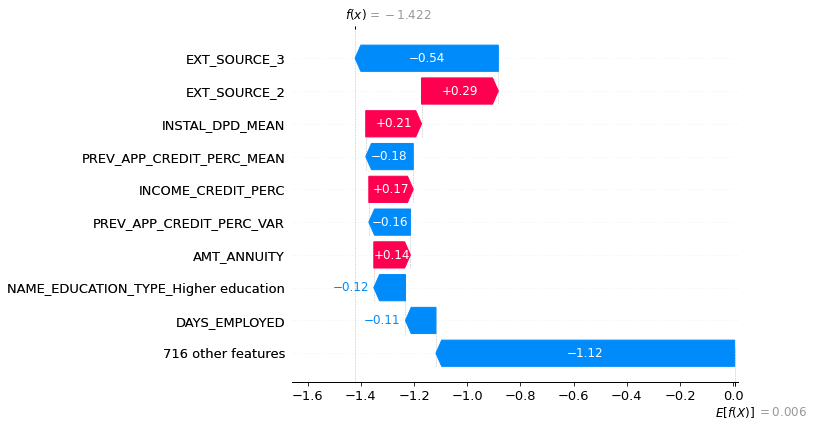

In [87]:
shap.plots.waterfall(shap_values_explaination[0])

Rmq : les shap values sont exprimées en log odds - on peut les retransformer en proba pour que les prédictions aient plus de sens pour nous.

In [72]:
y_test_pred = best_model_lgbm_fit.predict_proba(X_test.loc[[215797]])

print("Expected/Base Value : ", explainer.expected_value)

print("\nPrediction From Model                            : ", y_test_pred)
log_odds = np.array(explainer.expected_value) + np.array([shap_vals[0].sum(), shap_vals[1].sum()])
print("Prediction From Adding SHAP Values to Base Value : ", np.exp(log_odds)/(1 + np.exp(log_odds)))

Expected/Base Value :  [-0.005995046471776239, 0.005995046471776239]

Prediction From Model                            :  [[0.80559249 0.19440751]]
Prediction From Adding SHAP Values to Base Value :  [0.80559249 0.19440751]


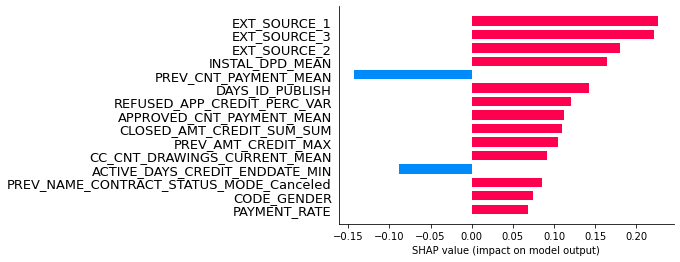

In [37]:
shap.bar_plot(shap_vals[0][0], feature_names=features_final, max_display=15)

On peut regarder l'importance de chaque variable sur l'ensemble des prédictions :

In [ ]:
X_test_transformed = best_model_lgbm_fit[0].transform(X_test)

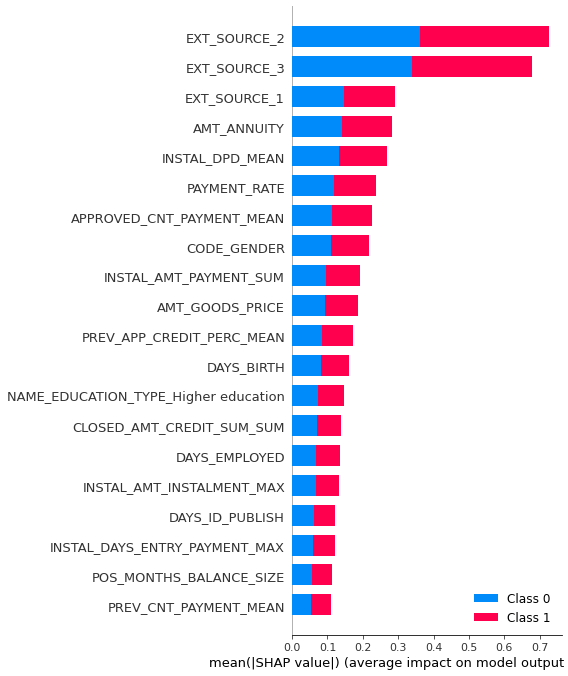

In [33]:
shap.summary_plot(explainer.shap_values(X_test_transformed),
                  features = X_test_transformed,
                  feature_names=features_final)

<h3 style="font-family:Corbel Light; color:#737373">Sauvegarde du modèle</h3>

In [32]:
model_dir = 'model'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [25]:
pickle_out = open(model_dir + "/classifier.pkl", "wb")
dill.dump(best_model_lgbm_fit, pickle_out)
pickle_out.close()

Vérifions qu'on arrive bien à faire des prédictions avec le modèle enregistré:

In [ ]:
pickle_in = open(model_dir + "/classifier.pkl", "rb")
classifier = dill.load(pickle_in)

In [75]:
p = classifier.predict_proba(X_test.loc[[215797]])

In [88]:
p[:,1]

array([0.19440751])

<h3 style="font-family:Corbel Light; color:#737373">Nearest Neighbors</h3>

Dans le dashboard demandé dans le projet, nous aurons besoin de comparer les infos relatives à un client à un groupe de clients similaires. Entrainons un modèle qui retournera les n plus proches voisins d'un client donné.

*Rappel: nous travaillons sur un échantillon du jeu de données, car mon ordinateur n'a pas les ressources nécessaires pour entrainer un modèle de classification sur le jeu complet*

In [ ]:
client_database = pd.read_pickle(data_dir + '/X_sample.pkl')

In [7]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_features = [col for col in client_database.columns
                  if client_database[col].dtype == 'object' and col not in binary_features]
numeric_features = client_database._get_numeric_data().columns

In [11]:
transformers_features = [{'feature': binary_features,
                          'estimator': [OrdinalEncoder(dtype=int)]},
                         {'feature': categ_features,
                          'estimator': [GetDummiesTransformer()]},
                         {'feature': numeric_features,
                          'estimator': [SimpleImputer(missing_values=np.nan, strategy='median'), RobustScaler()]}
                         ]

In [12]:
preprocessor = make_preprocessor(transformers_features)
neighbors = make_pipeline(preprocessor, NearestNeighbors(n_neighbors=10))

In [13]:
neighbors_fit = neighbors.fit(client_database)

Vérifions que le modèle fonctionne bien: 

In [19]:
transformed_data = neighbors_fit[0].transform(client_database.loc[[client_id]])

In [38]:
indices = neighbors_fit[1].kneighbors(transformed_data, n_neighbors= 20, return_distance=False)

In [39]:
indices[0].tolist()

[0,
 442,
 4231,
 75721,
 112615,
 86434,
 17463,
 4775,
 91241,
 72797,
 47208,
 43018,
 141924,
 79076,
 147960,
 1967,
 102113,
 12941,
 55014,
 30897]

In [40]:
client_database.iloc[indices[0].tolist()]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
386902,Cash loans,M,Y,N,0,292500.0,1350000.0,39474.0,1350000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115446,Cash loans,M,Y,Y,1,180000.0,755190.0,36459.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362884,Cash loans,F,Y,Y,0,112500.0,513531.0,35739.0,459000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387943,Cash loans,M,Y,Y,0,225000.0,835380.0,40320.0,675000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293029,Cash loans,M,Y,Y,0,112500.0,783927.0,40153.5,688500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367252,Cash loans,M,Y,N,0,135000.0,1078200.0,31522.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369889,Cash loans,F,N,Y,0,90000.0,900000.0,26446.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341320,Cash loans,M,Y,Y,0,247500.0,1006920.0,40063.5,900000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394630,Cash loans,M,Y,Y,0,112500.0,1107981.0,29358.0,967500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Enfin, enregistrons le modèle: 

In [42]:
pickle_out = open(model_dir + "/nearest_neighbors.pkl", "wb")
dill.dump(neighbors_fit, pickle_out)
pickle_out.close()

<h3 style="font-family:Corbel Light; color:#737373">Data Drift</h3>

Testons la librairie "evidently" pour détecter, dans le futur, du data drift en production.

Faisons l'hypothèse que : 
- le dataset 'application_train.csv' représente les données pour la modélisation
- le dataset 'application_test.csv' représente les données de nouveaux clients une fois le modèle en production

In [188]:
data_dir = 'data'

In [192]:
dataset_ref = pd.read_pickle(data_dir + '/application_train_clean.pkl')
target_ref = pd.read_pickle(data_dir + '/application_train_target.pkl')

dataset_cur = pd.read_pickle(data_dir + '/application_test_clean.pkl')

In [190]:
print('{:_} lignes dans jeu de données de référence et {:_} colonnes'.format(dataset_ref.shape[0], dataset_ref.shape[1]))
print('{:_} lignes dans jeu de données actuel et {:_} colonnes'.format(dataset_cur.shape[0], dataset_cur.shape[1]))

307_507 lignes dans jeu de données de référence et 458 colonnes
48_744 lignes dans jeu de données actuel et 458 colonnes


La détection du datadrift prend trop de temps sur le jeu de données entier, nous allons travailler sur un échantillon juste pour comprendre le fonctionnement de la librairie evidently

In [193]:
dataset_cur = dataset_cur.sample(n=300, random_state=8)

dataset_ref, target_ref = resample(dataset_ref,
                                   target_ref,
                                   n_samples=500,
                                   stratify=target_ref,
                                   random_state=8
                                   )

In [194]:
print('{:_} lignes dans jeu de données de référence et {:_} colonnes'.format(dataset_ref.shape[0], dataset_ref.shape[1]))
print('{:_} lignes dans jeu de données actuel et {:_} colonnes'.format(dataset_cur.shape[0], dataset_cur.shape[1]))

500 lignes dans jeu de données de référence et 458 colonnes
300 lignes dans jeu de données actuel et 458 colonnes


In [195]:
dataset_ref.index.names = ['index']
dataset_cur.index.names = ['index']

In [196]:
dataset_ref.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
256303,Cash loans,F,N,Y,0,90000.0,239850.0,22671.0,225000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156621,Cash loans,M,Y,N,0,225000.0,550980.0,43659.0,450000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
dataset_cur.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
433343,Cash loans,F,N,Y,1,166500.0,280170.0,29547.0,247500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427138,Cash loans,M,Y,Y,0,166500.0,323460.0,27891.0,270000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [200]:
%%time
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=dataset_cur, reference_data=dataset_ref, column_mapping=None)

CPU times: total: 6min 41s
Wall time: 6min 57s


In [203]:
data_drift_report.save_html('data_drift_report.html')

In [207]:
data_drift_report_json = json.loads(data_drift_report.json())

Du drift est détecté sur seulement 14% des variables (ce qui est en dessous du seuil de 50%). Donc evidently considère qu'il n'y a pas de data drift entre ces deux échantillons de données.

In [221]:
print('N° of drifted columns: ', data_drift_report_json['metrics'][0]['result']['number_of_drifted_columns'])
print('Share of drifted columns:', round(data_drift_report_json['metrics'][0]['result']['share_of_drifted_columns']* 100, 1), '%')
print('Data Drift ?: ', data_drift_report_json['metrics'][0]['result']['dataset_drift'])

N° of drifted columns:  62
Share of drifted columns: 13.5 %
Data Drift ?:  False


Regardons rapidement si les 62 variables pour lesquelles du drift a été détecté font parties des variables les plus utilisées par le modèle: 

*remarque : le code ci-dessous n'est pas très joli mais efficace :)*

In [266]:
columns = data_drift_report_json["metrics"][1]['result']['drift_by_columns']
drifted_columns = []

for column_name, drift_report in columns.items():
    if drift_report['drift_detected']==True:
        drifted_columns.append({'feature': column_name, 
                                'type': drift_report['column_type'], 
                                'split': None})
        
drifted_columns_df = pd.DataFrame(drifted_columns)

In [267]:
drifted_columns_df.shape

(62, 3)

In [268]:
feature_imp_df = feature_imp_df.sort_values('Split', ascending=False)

In [269]:
mask_num = (drifted_columns_df['type'] == 'num')
drifted_columns_df.loc[mask_num, 'split'] = drifted_columns_df.loc[mask_num, 'feature'].apply(
    lambda r: feature_imp_df.loc[feature_imp_df['Feature Name'] == r, "Split"].values[0])

In [270]:
mask_cat = (drifted_columns_df['type'] == 'cat')

drifted_columns_df.loc[mask_cat, 'split'] = drifted_columns_df.loc[mask_cat, 'feature'].apply(
    lambda r: feature_imp_df.loc[feature_imp_df['Feature Name'].str.contains(r + '_'), "Split"].values[0])

Il semblerait que seules 40 de ces variables soient vraiment utilisées par le modèle.

In [271]:
mask_used = (drifted_columns_df['split'] > 0)
drifted_columns_df.loc[mask_used].shape

(40, 3)

Malheureusement, du drift est détecté sur la variable la plus utilisée par le modèle : "PAYMENT_RATE".
Cette variable ayant un impact très important sur les prédictions, ne vaudrait-il pas mieux ré-entrainer le modèle malgré le rapport négatif de evidently ?

In [273]:
drifted_columns_df.loc[mask_used].sort_values('split', ascending=False)

,feature,type,split
41,PAYMENT_RATE,num,35
33,DAYS_ID_PUBLISH,num,10
8,AMT_GOODS_PRICE,num,9
29,CLOSED_DAYS_CREDIT_MAX,num,7
3,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,num,6
7,AMT_CREDIT,num,6
28,CLOSED_AMT_CREDIT_SUM_SUM,num,6
30,CLOSED_MONTHS_BALANCE_SIZE_MEAN,num,5
22,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,num,5
40,INCOME_CREDIT_PERC,num,5
